## ALGORITMOS BASADOS EN MACHINE LEARNING

Los __algoritmos de *trading* basados en *machine learning*__ que vamos a diseñar tienen __dos componentes__:   
__(1)__ Un <u>modelo</u> que predice la siguiente cotización de la criptomoneda, en el siguiente intervalo y en determinada frecuencia.  
__(2)__ Un <u>*script*</u>, que refleja la estrategia de *trading* que seguirá el algoritmo, y que toma como ímput el valor predicho por el modelo.

En primer lugar, vamos a entrenar distintos modelos de *Machine Learning* para __predecir la cotización__ de una criptomoneda en __intervalos de 15 minutos__. Para ello emplearemos como <u>variables predictoras</u> las cotizaciones de algunos índices bursátiles relevantes.  
En los casos en que queramos predecir criptomonedas distintas del Bitcoin, incluiremos también esta criptomoneda entre las variables predictoras, puesto que la experiencia histórica muestra que la cotización de gran parte de las criptomonedas del mercado está fuertemente influida por ella, por el Bitcoin.

In [11]:
# Carga de las librerías y clases que vamos a utilizar
from skimpy import skim 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro, kstest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
warnings.filterwarnings("ignore")

#### Carga y limpieza del dataset de la __criptomoneda cuya cotización ha de predecirse__ (en este caso, __Chainlink__).

En primer lugar, importamos la librería creada *ad hoc* para la descarga de los datos depositados en las tablas *silver*.

In [14]:
# import cryptoengineersdk as ce

In [15]:
"""
# Autenticación del usuario para uso de la librería cryptoengineersdk
user_token = {
    "user": "hector",
    "token": "a9agHyfg5478GfufUfj98534fs4gHh89Ig7v6fG89kJy7U5f5FFhjU88"
}
"""

'\n# Autenticación del usuario para uso de la librería cryptoengineersdk\nuser_token = {\n    "user": "hector",\n    "token": "a9agHyfg5478GfufUfj98534fs4gHh89Ig7v6fG89kJy7U5f5FFhjU88"\n}\n'

In [16]:
"""
# Definición de las variables para recoger los activos e indicadores cuyas cotizaciones se rescatarán de la base de datos  
crypto_list = ["XBTUSD", "ETHUSD", "LINKUSD", "XDGUSD"]
indexes_list = ["EuroStoxx50", "DAX", "IBEX35", "Nasdaq", "DowJones", "Nikkei225", "SP500"]
forex_list = ["USDJPY", "USDEUR", "USDGBP", "USDCHF"]
commodities_list = ["BZUSD", "CLUSD", "GCUSD", "NGUSD"]

# Determinación del rango de fechas de lasw cotizaciones.
from_year = 2010
to_year = 2024
"""

'\n# Definición de las variables para recoger los activos e indicadores cuyas cotizaciones se rescatarán de la base de datos  \ncrypto_list = ["XBTUSD", "ETHUSD", "LINKUSD", "XDGUSD"]\nindexes_list = ["EuroStoxx50", "DAX", "IBEX35", "Nasdaq", "DowJones", "Nikkei225", "SP500"]\nforex_list = ["USDJPY", "USDEUR", "USDGBP", "USDCHF"]\ncommodities_list = ["BZUSD", "CLUSD", "GCUSD", "NGUSD"]\n\n# Determinación del rango de fechas de lasw cotizaciones.\nfrom_year = 2010\nto_year = 2024\n'

In [17]:
"""
for crypto in crypto_list:
    table_name = "silver_t_cryptos"
    symbol = crypto
    from_year = from_year
    to_year = to_year
    df = ce.reader(user_token, table_name, symbol, from_year, to_year)
    df.to_csv(f"New data/dataset_{crypto}.csv")
"""

'\nfor crypto in crypto_list:\n    table_name = "silver_t_cryptos"\n    symbol = crypto\n    from_year = from_year\n    to_year = to_year\n    df = ce.reader(user_token, table_name, symbol, from_year, to_year)\n    df.to_csv(f"New data/dataset_{crypto}.csv")\n'

In [18]:
"""
# Bucle para pedir las cotizaciones de las criptomonedas y guardarlas en datasets independientes.
for crypto in crypto_list:
    table_name = "silver_t_cryptos"
    symbol = crypto
    from_year = from_year
    to_year = to_year
    df = ce.reader(user_token, table_name, symbol, from_year, to_year)
    df.to_csv(f"New data/Crypto/dataset_{crypto}.csv")
    
# Bucle para pedir las cotizaciones de los índices y guardarlas en datasets independientes.
for index in indexes_list:
    table_name = "silver_t_indices"
    symbol = index
    from_year = from_year
    to_year = to_year
    df = ce.reader(user_token, table_name, symbol, from_year, to_year)
    df.to_csv(f"New data/Index/dataset_{index}.csv")

# Bucle para pedir las cotizaciones de los tipos de cambio y guardarlas en datasets independientes.
for forex in forex_list:
    table_name = "silver_t_forex"
    symbol = forex
    from_year = from_year
    to_year = to_year
    df = ce.reader(user_token, table_name, symbol, from_year, to_year)
    df.to_csv(f"New data/Forex/dataset_{forex}.csv")

# Bucle para pedir las cotizaciones de las mercancías y guardarlas en datasets independientes.
for commoditie in commodities_list:
    table_name = "silver_t_commodities"
    symbol = commoditie
    from_year = from_year
    to_year = to_year
    df = ce.reader(user_token, table_name, symbol, from_year, to_year)
    df.to_csv(f"New data/Commodities/dataset_{commoditie}.csv")
"""

'\n# Bucle para pedir las cotizaciones de las criptomonedas y guardarlas en datasets independientes.\nfor crypto in crypto_list:\n    table_name = "silver_t_cryptos"\n    symbol = crypto\n    from_year = from_year\n    to_year = to_year\n    df = ce.reader(user_token, table_name, symbol, from_year, to_year)\n    df.to_csv(f"New data/Crypto/dataset_{crypto}.csv")\n    \n# Bucle para pedir las cotizaciones de los índices y guardarlas en datasets independientes.\nfor index in indexes_list:\n    table_name = "silver_t_indices"\n    symbol = index\n    from_year = from_year\n    to_year = to_year\n    df = ce.reader(user_token, table_name, symbol, from_year, to_year)\n    df.to_csv(f"New data/Index/dataset_{index}.csv")\n\n# Bucle para pedir las cotizaciones de los tipos de cambio y guardarlas en datasets independientes.\nfor forex in forex_list:\n    table_name = "silver_t_forex"\n    symbol = forex\n    from_year = from_year\n    to_year = to_year\n    df = ce.reader(user_token, table_nam

In [19]:
"""
# Petición y guardado del dataset de la criptomoneda USDT (Token USD)
table_name = "silver_t_cryptos"
symbol = "USDTUSD"
from_year = 2010
to_year = 2024
df = ce.reader(user_token, table_name, symbol, from_year, to_year)
df.to_csv("New data/dataset_USDTUSD.csv")
"""

'\n# Petición y guardado del dataset de la criptomoneda USDT (Token USD)\ntable_name = "silver_t_cryptos"\nsymbol = "USDTUSD"\nfrom_year = 2010\nto_year = 2024\ndf = ce.reader(user_token, table_name, symbol, from_year, to_year)\ndf.to_csv("New data/dataset_USDTUSD.csv")\n'

Una vez descargados los datos, procedemos a recuperarlos en forma de *dataframes* de Pandas, para su análisis y tratamiento.

In [21]:
# Datasets disponibles de criptomonedas
crypto_list = ["XBTUSD", "ETHUSD", "LINKUSD", "XDGUSD"]

In [22]:
# Elección de la criptomoneda cuyas cotizaciones se pretende predecir, es decir aquella con símbolo "LINKUSD".
crypto_file = crypto_list[2]

In [23]:
# Función de carga del las cotizaciones de la criptomoneda
def load_crypto(crypto_name_file):
    
    # Definición del título de las columnas
    columns_names = [
        "idx",
        "Base_currency",
        "Type",
        "DateTime",
        "Date",
        "Time",
        "Frequency",
        "Month",
        "Day",
        f"{crypto_file}_Open",
        f"{crypto_file}_High",
        f"{crypto_file}_Low",
        f"{crypto_file}_Close", 
        f"{crypto_file}_Volume_USD", 
        f"{crypto_file}_Trades",
        "Audit_Time",
        "Symbol",
        "Year",
    ]
    
    # Carga del fichero de la criptomoneda
    df_crypto = pd.read_csv(f"New data/Crypto/dataset_{crypto_file}.csv", delimiter= ",", header=None)
     
    # Añadir el nombre de las columnas al dataset
    df_crypto.columns = columns_names

    # Seleccionar únicamente las columnas con las que vamos a trabajar: una columna de fecha y otra columna con el precio de cierre para cada período temporal.
    df_crypto = df_crypto[["DateTime", f"{crypto_file}_Close"]]

    # Eliminar primera fila, correspondiente al encabezado existente en la tabla por defecto, que contiene nombres de columna inadecuados para nuestra tarea.
    df_crypto = df_crypto.drop(index=0).reset_index(drop=True)

    # Convertir en formato fecha la columna "DateTime".
    df_crypto["DateTime"] = pd.to_datetime(df_crypto["DateTime"])

    # Ordenar los registros en función del DateTime, esto es, cronológicamente
    df_crypto = df_crypto.sort_values(by= "DateTime")

    # Convertir columna de fecha en índice
    df_crypto = df_crypto.set_index("DateTime")

    # Castear los valores de las cotizaciones a tipo "float"
    for column in df_crypto.columns:
        df_crypto[column] = df_crypto[column].astype("float64")
    
    # Muestra del dataset
    return df_crypto

In [24]:
# Carga del dataset de la criptomoneda cuyos precios se deben predecirb
df_crypto = load_crypto(f"{crypto_file}.csv")
df_crypto

,LINKUSD_Close
DateTime,
2019-09-25 14:00:00,1.90000
2019-09-25 14:15:00,1.79000
2019-09-25 14:30:00,1.72000
2019-09-25 14:45:00,1.86900
2019-09-25 15:15:00,1.79000
...,...
2024-09-22 23:00:00,11.14369
2024-09-22 23:15:00,11.10494
2024-09-22 23:30:00,11.12870


Como podemos observar, los datos disponibles empiezan el __25/09/2019__ a las 14:00:00 horas y finalizan el __23/09/2024__ a las 00:00:00 horas.

#### Análisis exploratorio del dataset de la criptomoneda cuyas cotizaciones han de ser predichos

In [27]:
# Desplegar algunos datos estadísticos y de valores faltantes
skim(df_crypto)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 164959 │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0   ┃ p25     ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ LINKUSD_Close     │   0 │      0 │   13.42 │   8.767 │  1.5 │   6.882 │  11.45 │  17.81 │  52.65 │  ▇▆▂▁   │  │
│ └───────────────────┴─────┴────────┴─────────┴─────────┴──────┴─────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Observamos que no existen valores faltantes y que los mínimos y máximos son coherentes con las cotizaciones históricas de la cripmoneda.

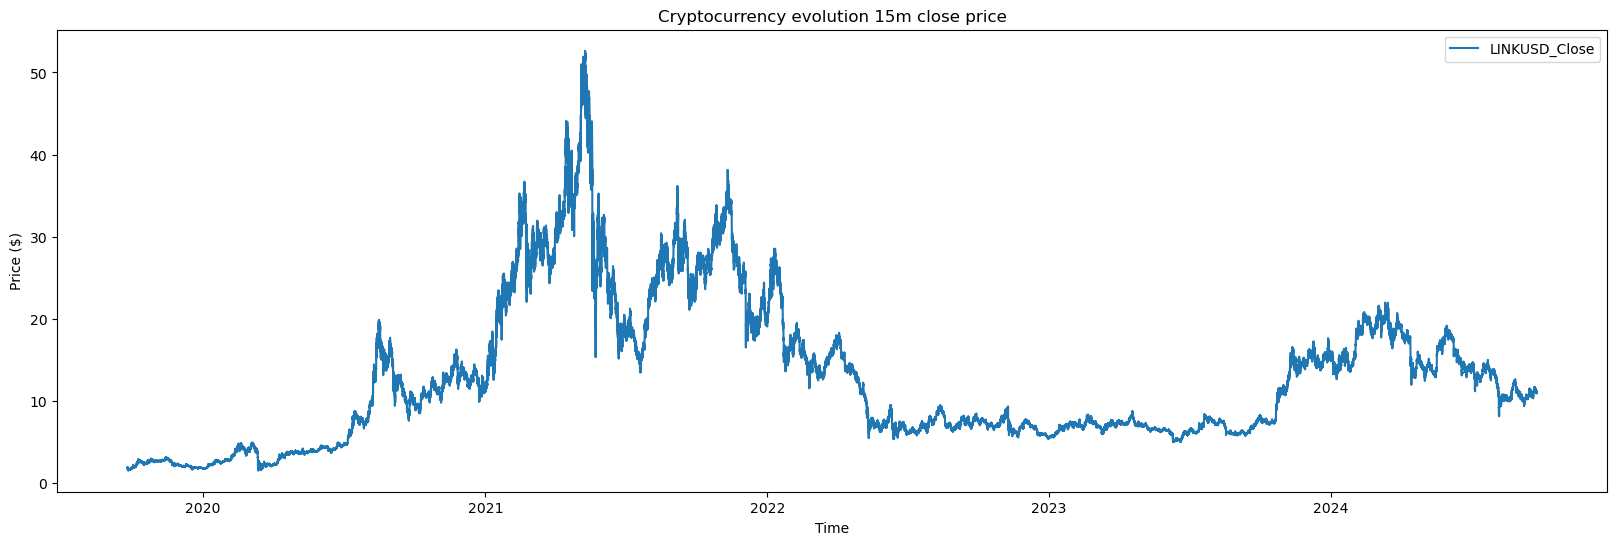

In [29]:
# Representamos en un gráfico la evolución de la cotización de la criptomoneda cuyo valor ha de predecirse
plt.figure(figsize=(20,6))
plt.plot(df_crypto, label=df_crypto.columns)
plt.title("Cryptocurrency evolution 15m close price")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

<u>Comentario</u>: Chainlink no empezó a tener una presencia relevante en el mercado, en términos de volumen negociado, hasta inicios de 2020, aproximadamente.

Dado que se trata de una serie temporal, procedemos a comprobar si existen fechas duplicadas en el índice. 

In [32]:
# Verificar si el índice es único
if df_crypto.index.is_unique:
    print("El índice no tiene valores duplicados.")
else:
    print("Hay valores duplicados en el índice.")

Hay valores duplicados en el índice.


Existen fechas duplicadas en el índice. Comprobamos cuáles son:

In [34]:
# Verificar si hay índices duplicados
duplicados = df_crypto.index.duplicated()

# Mostrar filas con índices duplicados
df_crypto[duplicados]

,LINKUSD_Close
DateTime,
2024-09-21 00:15:00,11.45191
2024-09-21 00:30:00,11.47175
2024-09-21 00:45:00,11.44000
2024-09-21 01:00:00,11.43552
2024-09-21 01:15:00,11.42359
...,...
2024-09-21 22:45:00,11.41729
2024-09-21 23:00:00,11.39453
2024-09-21 23:15:00,11.43417


Parece que solo afecta a las cotizaciones del día 21 de septiembre de 2024.

In [36]:
# Filtramos el dataset por esa fecha
df_crypto.loc["2024-09-21"]

,LINKUSD_Close
DateTime,
2024-09-21 00:00:00,11.38763
2024-09-21 00:15:00,11.45191
2024-09-21 00:15:00,11.45191
2024-09-21 00:30:00,11.47175
2024-09-21 00:30:00,11.47175
...,...
2024-09-21 23:15:00,11.43417
2024-09-21 23:30:00,11.50421
2024-09-21 23:30:00,11.50421


Existen fecha duplicadas para las cotizaciones del día 2024-09-21. Observamos que las cotizaciones correspondientes a estos índices (fechas) también está duplicadas. Procedemos a eliminar estos registros sobrantes.

In [38]:
# Eliminar filas con índices duplicados, manteniendo solo la primera entrada/cotización
df_crypto = df_crypto[~df_crypto.index.duplicated(keep="first")]

# Verificar si el índice es único
if df_crypto.index.is_unique:
    print("El índice no tiene valores duplicados.")
else:
    print("Hay valores duplicados en el índice.")

El índice no tiene valores duplicados.


#### Carga limpieza y exploración del dataset de Bitcoin (una de las variables predictoras)

In [40]:
# Carga del fichero del Bitcoin
crypto_file = crypto_list[0]
df_bitcoin = load_crypto(f"{crypto_file}.csv")
df_bitcoin

,XBTUSD_Close
DateTime,
2013-10-06 21:30:00,122.00
2013-10-07 20:45:00,123.61
2013-10-08 02:45:00,123.90
2013-10-08 05:15:00,124.18
2013-10-09 09:30:00,123.84
...,...
2024-09-22 23:00:00,63615.20
2024-09-22 23:15:00,63510.80
2024-09-22 23:30:00,63620.80


In [41]:
# Desplegar algunos datos estadísticos
skim(df_bitcoin)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 317098 │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25    ┃ p50     ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ XBTUSD_Close     │   0 │      0 │   19730 │   19810 │   122 │   3968 │   10220 │  31330 │  73620 │ ▇▂▂▁▁▁  │  │
│ └──────────────────┴─────┴────────┴─────────┴─────────┴───────┴────────┴─────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

No existen valores nulos en el dataframe. Además, los mínimos y máximos son coherentes con el rango de precios en el que se ha mantenido el Bitcoin en el intervalo temporal disponible.

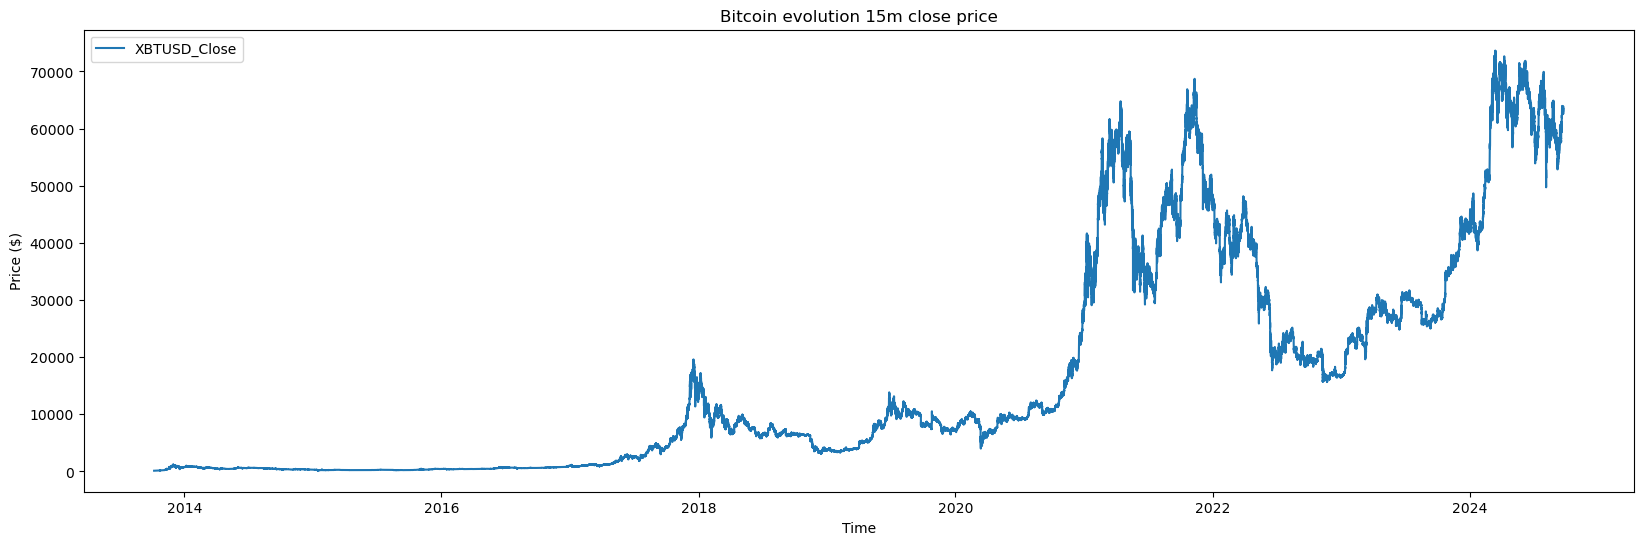

In [43]:
# Representamos en un gráfico la evolución de la cotización del Bitcoin
plt.figure(figsize=(20,6))
plt.plot(df_bitcoin, label=df_bitcoin.columns)
plt.title("Bitcoin evolution 15m close price")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

Una comparación visual entre el gráfico de la cotización de Ethereum sugiere, como dijimos al principio, un comportamiento fluctuante y tendencial muy similar al del Bitcoin. Ello no implica de por sí causalidad en ningún sentido. No obstante, a nuestro juicio, la experiencia histórica sí sugiere influencia causal de la cotización del Bitcoin en la de Ethereum y otras criptomonedas.

In [45]:
# Verificar si el índice es único
if df_bitcoin.index.is_unique:
    print("El índice no tiene valores duplicados.")
else:
    print("Hay valores duplicados en el índice.")

Hay valores duplicados en el índice.


In [46]:
# Verificar si hay índices duplicados
duplicados_bitcoin = df_bitcoin.index.duplicated()

# Mostrar filas con índices duplicados
df_bitcoin[duplicados_bitcoin]

,XBTUSD_Close
DateTime,
2024-09-21 00:15:00,63167.9
2024-09-21 00:30:00,63262.8
2024-09-21 00:45:00,63206.6
2024-09-21 01:00:00,63050.1
2024-09-21 01:15:00,63050.0
...,...
2024-09-21 22:45:00,63247.0
2024-09-21 23:00:00,63199.3
2024-09-21 23:15:00,63327.1


Al igual que ocurría con el dataset de Chainlink, el de Bitcoin también contiene índices duplicados en la fecha 2024-09-21

In [48]:
# Eliminar filas con índices duplicados, manteniendo solo la primera entrada/cotización
df_bitcoin = df_bitcoin[~df_bitcoin.index.duplicated(keep="first")]

# Verificar si el índice es único
if df_bitcoin.index.is_unique:
    print("El índice no tiene valores duplicados.")
else:
    print("Hay valores duplicados en el índice.")

El índice no tiene valores duplicados.


#### Carga y limpieza de los datasets del resto de variables predictoras, esto es, los índices.

In [50]:
# Carga del fichero del índice DAX (Alemania) 
df_DAX = pd.read_csv(f"New Data/Index/dataset_DAX.csv", delimiter= ",", header=None)
# Carga del fichero del índice Nikkei-225 
df_Nikkei = pd.read_csv(f"New Data/Index/dataset_Nikkei225.csv", delimiter= ",", header=None)
# Carga del fichero del índice NASDAQ-100) 
df_Nasdaq = pd.read_csv(f"New Data/Index/dataset_Nasdaq.csv", delimiter= ",", header=None)
# Carga del fichero del índice IBEX-35 
df_IBEX35 = pd.read_csv(f"New Data/Index/dataset_IBEX35.csv", delimiter= ",", header=None)
# Carga del fichero del índice S&P 500 
df_SP500 = pd.read_csv(f"New Data/Index/dataset_SP500.csv", delimiter= ",", header=None)
# Carga del fichero del índice EUROSTOXX-50
df_STOXX50 = pd.read_csv(f"New Data/Index/dataset_EuroStoxx50.csv", delimiter= ",", header=None)                          
# Carga del fichero del índice Dow Jones-30
df_DowJones = pd.read_csv(f"New Data/Index/dataset_DowJones.csv", delimiter= ",", header=None)
                         
# Modificación del título de las columnas para el índice DAX (Alemania)
DAX_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "DAX_Open",  "DAX_High",
                        "DAX_Low", "DAX_Close", "DAX_Volume_USD", "DAX_Trades", "Audit_Time", "Symbol", "Year"]
df_DAX.columns = DAX_columns_names
# Modificación del título de las columnas para el índice Nikkei-225
Nikkei_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "Nikkei_Open",  "Nikkei_High",
                        "Nikkei_Low", "Nikkei_Close", "Nikkei_Volume_USD", "Nikkei_Trades", "Audit_Time", "Symbol", "Year"]
df_Nikkei.columns = Nikkei_columns_names
# Modificación del título de las columnas para el índice NASDAQ-100
Nasdaq_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "Nasdaq_Open",  "Nasdaq_High",
                        "Nasdaq_Low", "Nasdaq_Close", "Nasdaq_Volume_USD", "Nasdaq_Trades", "Audit_Time", "Symbol", "Year"]
df_Nasdaq.columns = Nasdaq_columns_names
# Modificación del título de las columnas para el índice IBEX-35
IBEX35_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "IBEX35_Open",  "IBEX35_High",
                        "IBEX35_Low", "IBEX35_Close", "IBEX35_Volume_USD", "IBEX35_Trades", "Audit_Time", "Symbol", "Year"]
df_IBEX35.columns = IBEX35_columns_names
# Modificación del título de las columnas para el índice S&P 500
SP500_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "SP500_Open",  "SP500_High",
                        "SP500_Low", "SP500_Close", "SP500_Volume_USD", "SP500_Trades", "Audit_Time", "Symbol", "Year"]
df_SP500.columns = SP500_columns_names
# Modificación del título de las columnas para el índice EUROSTOXX-50
STOXX50_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "STOXX50_Open",  "STOXX50_High",
                        "STOXX50_Low", "STOXX50_Close", "STOXX50_Volume_USD", "STOXX50_Trades", "Audit_Time", "Symbol", "Year"]
df_STOXX50.columns = STOXX50_columns_names
# Modificación del título de las columnas para el índice Dow Jones-30
DowJones_columns_names = ["idx", "Base_currency", "Type","DateTime", "Date", "Time", "Frequency" ,"Month", "Day", "DowJones_Open",  "DowJones_High",
                        "DowJones_Low", "DowJones_Close", "DowJones_Volume_USD", "DowJones_Trades", "Audit_Time", "Symbol", "Year"]
df_DowJones.columns = DowJones_columns_names

# Seleccionar únicamente las columnas que necesitamos
df_DAX = df_DAX.iloc[:, [4,5,12]]
df_Nikkei = df_Nikkei.iloc[:, [4,5,12]]
df_Nasdaq = df_Nasdaq.iloc[:, [4,5,12]]
df_IBEX35 = df_IBEX35.iloc[:, [4,5,12]]
df_SP500 = df_SP500.iloc[:, [4,5,12]]
df_STOXX50 = df_STOXX50.iloc[:, [4,5,12]]
df_DowJones = df_DowJones.iloc[:, [4,5,12]]

# Eliminar primera fila, correspondiente al encabezado por defecto.
df_DAX = df_DAX.drop(index=0).reset_index(drop=True)
df_Nikkei = df_Nikkei.drop(index=0).reset_index(drop=True)
df_IBEX35 = df_IBEX35.drop(index=0).reset_index(drop=True)
df_Nasdaq = df_Nasdaq.drop(index=0).reset_index(drop=True)
df_SP500 = df_SP500.drop(index=0).reset_index(drop=True)
df_STOXX50 = df_STOXX50.drop(index=0).reset_index(drop=True)
df_DowJones = df_DowJones.drop(index=0).reset_index(drop=True)

# Concatenar las columnas "Date" y "Time", para hacer cuadrar la estructura de los datos de fecha con la del resto de datasets
df_DAX["DateTime"] = pd.to_datetime(df_DAX["Date"] + ' ' + df_DAX["Time"])
df_Nikkei["DateTime"] = pd.to_datetime(df_Nikkei["Date"] + ' ' + df_Nikkei["Time"])
df_Nasdaq["DateTime"] = pd.to_datetime(df_Nasdaq["Date"] + ' ' + df_Nasdaq["Time"])
df_IBEX35["DateTime"] = pd.to_datetime(df_IBEX35["Date"] + ' ' + df_IBEX35["Time"])
df_SP500["DateTime"] = pd.to_datetime(df_SP500["Date"] + ' ' + df_SP500["Time"])
df_STOXX50["DateTime"] = pd.to_datetime(df_STOXX50["Date"] + ' ' + df_STOXX50["Time"])
df_DowJones["DateTime"] = pd.to_datetime(df_DowJones["Date"] + ' ' + df_DowJones["Time"])

# Eliminar las columnas Date y Time, que ya no vamos a utilizar
df_DAX = df_DAX[["DateTime", "DAX_Close"]]
df_Nikkei = df_Nikkei[["DateTime", "Nikkei_Close"]]
df_Nasdaq = df_Nasdaq[["DateTime", "Nasdaq_Close"]]
df_IBEX35 = df_IBEX35[["DateTime", "IBEX35_Close"]]
df_SP500 = df_SP500[["DateTime", "SP500_Close"]]
df_STOXX50 = df_STOXX50[["DateTime", "STOXX50_Close"]] 
df_DowJones = df_DowJones[["DateTime", "DowJones_Close"]]

# Convertir columnas de fecha en índices
df_DAX = df_DAX.set_index("DateTime")
df_Nikkei = df_Nikkei.set_index("DateTime")
df_Nasdaq = df_Nasdaq.set_index("DateTime")
df_IBEX35 = df_IBEX35.set_index("DateTime")
df_SP500 = df_SP500.set_index("DateTime")
df_STOXX50 = df_STOXX50.set_index("DateTime")
df_DowJones = df_DowJones.set_index("DateTime")

# Castear valores a flotantes
df_DAX.iloc[:, 0] = df_DAX.iloc[:, 0].astype("float64")
df_Nikkei.iloc[:, 0] = df_Nikkei.iloc[:, 0].astype("float64")
df_Nasdaq.iloc[:, 0] = df_Nasdaq.iloc[:, 0].astype("float64")
df_IBEX35.iloc[:, 0] = df_IBEX35.iloc[:, 0].astype("float64")
df_SP500.iloc[:, 0] = df_SP500.iloc[:, 0].astype("float64")
df_STOXX50.iloc[:, 0] = df_STOXX50.iloc[:, 0].astype("float64")
df_DowJones.iloc[:, 0] = df_DowJones.iloc[:, 0].astype("float64")

# Desindexar la columna DateTime para limpiarla y darle formato de fecha
df_DAX = df_DAX.reset_index()
df_Nikkei = df_Nikkei.reset_index()
df_Nasdaq = df_Nasdaq.reset_index()
df_IBEX35 = df_IBEX35.reset_index()
df_SP500 = df_SP500.reset_index()
df_STOXX50 = df_STOXX50.reset_index()
df_DowJones = df_DowJones.reset_index()

# Dar formato de fecha a la columna DateTime
df_DAX["DateTime"] = pd.to_datetime(df_DAX["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_Nikkei["DateTime"] = pd.to_datetime(df_Nikkei["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_Nasdaq["DateTime"] = pd.to_datetime(df_Nasdaq["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_IBEX35["DateTime"] = pd.to_datetime(df_IBEX35["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_SP500["DateTime"] = pd.to_datetime(df_SP500["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_STOXX50["DateTime"] = pd.to_datetime(df_STOXX50["DateTime"], format = "%Y-%m-%d %H:%M:%S")
df_DowJones["DateTime"] = pd.to_datetime(df_DowJones["DateTime"], format = "%Y-%m-%d %H:%M:%S")

# Reindexar la columna DateTime
df_DAX = df_DAX.set_index("DateTime")
df_Nikkei = df_Nikkei.set_index("DateTime")
df_Nasdaq = df_Nasdaq.set_index("DateTime")
df_IBEX35 = df_IBEX35.set_index("DateTime")
df_SP500 = df_SP500.set_index("DateTime")
df_STOXX50 = df_STOXX50.set_index("DateTime")
df_DowJones = df_DowJones.set_index("DateTime")

#### Análisis exploratorio de los datasets del resto de variables predictoras, esto es, de los índices.

Al tratarse de series temporalers, en primer lugar crearemos una función para asegurarnos de que todas las fechas están separadas en intervalos de 15 minutos.

In [55]:
# Función para comprobar si todos los índices están separados por frecuencias de 15 minutos
def time_difference(df):
    # Calcular la diferencia de tiempo entre los índices consecutivos
    df["time_difference"] = df.index.to_series().diff()
    
    # Filtrar las filas donde la diferencia de tiempo es de 15 minutos
    df_15_min = df[df["time_difference"] == pd.Timedelta(minutes=15)]
    
    # Obtener la primera fecha con frecuencia de 15 minutos
    if not df_15_min.empty:
        first_15_min_date = df_15_min.index[0]
        print(f"La frecuencia de 15 minutos comienza a partir del: {first_15_min_date}")
    else:
        print("No se encontraron registros con una frecuencia de 15 minutos.")

Creamos una función que contiene distintas operaciones que serán útiles en nuestro análisis exploratorio, incluyendo la función anterior.

In [58]:
def exploratory_feature_analysis(df):
    # Desplegar dataframe del índice
    print("DataFrame (primeras filas):")
    print(df)
    # Añadir separación
    print("\n" + "-"*50 + "\n")
    
    # Comprobar en qué fecha inicia el dataset
    print(f"Fecha de inicio del dataset: {df.index[0]}")
    print("\n" + "-"*50 + "\n")

    # Comprobar si todos los índices están distribuidos en intervalos de 15 minutos
    print("Comprobación de intervalos de 15 minutos:")
    time_difference(df)
    print("\n" + "-"*50 + "\n")

    # Eliminar la columna usada para comprobar las frecuencias de cotización
    df = df.iloc[:, [0]]
    
    # Desplegar algunos datos estadísticos del dataset
    print("Datos estadísticos del dataset:")
    skim(df)
    print("\n" + "-"*50 + "\n")

    # Representar en un gráfico la evolución de la cotización del índice
    print("Representación gráfica de la cotización del índice:")
    plt.figure(figsize=(20,6))
    plt.plot(df.index, df.iloc[:, [0]], label=df.columns[0])
    plt.title(f"{df.columns[0]} 15m price")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()
    print("\n" + "-"*50 + "\n")

    # Verificar si el índice es único
    if df.index.is_unique:
        print("El índice no tiene valores duplicados.")
    else:
        print("Hay valores duplicados en el índice.")
    print("\n" + "-"*50 + "\n")

    # Verificar si hay índices duplicados
    duplicados = df.index.duplicated()

    # Mostrar filas con índices duplicados
    if duplicados.any():
        print("Filas con índices duplicados:")
        print(df[duplicados])
    else:
        print("No hay índices duplicados.")
    print("\n" + "-"*50 + "\n")

##### - Aplicación de la función al dataset del índice __DAX__

DataFrame (primeras filas):
                        DAX_Close
DateTime                         
2021-09-06 07:00:00  15833.900391
2021-09-06 07:15:00  15874.900391
2021-09-06 07:30:00  15880.950195
2021-09-06 07:45:00  15873.950195
2021-09-06 08:00:00  15871.400391
...                           ...
2024-09-03 14:30:00  18757.449219
2024-09-03 14:45:00  18739.949219
2024-09-03 15:00:00  18752.449219
2024-09-03 15:15:00  18756.949219
2024-09-03 15:30:00  18754.949219

[26995 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-06 07:00:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-06 07:15:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 26995  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0      ┃ p25     ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ DAX_Close       │   0 │      0 │   15590 │   1658 │   11880 │   14410 │  15610 │  16460 │  18990 │ ▂▃▆▇▂▃  │  │
│ └─────────────────┴─────┴────────┴─────────┴────────┴─────────┴─────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


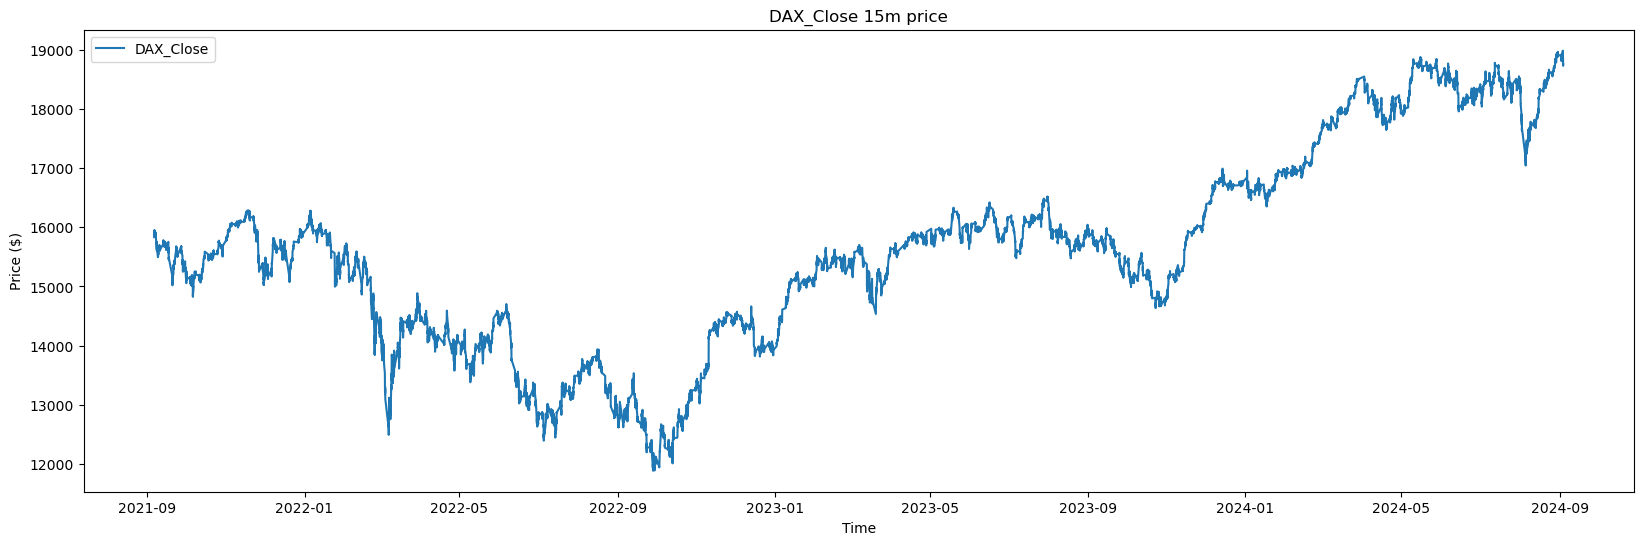


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [61]:
exploratory_feature_analysis(df_DAX)

##### - Aplicación de la función al dataset del índice __Nikkei__

DataFrame (primeras filas):
                    Nikkei_Close
DateTime                        
2021-09-06 00:00:00      29545.5
2021-09-06 00:15:00      29546.5
2021-09-06 00:30:00      29493.0
2021-09-06 00:45:00      29588.5
2021-09-06 01:00:00      29614.5
...                          ...
2024-09-03 05:00:00      38676.5
2024-09-03 05:15:00      38626.5
2024-09-03 05:30:00      38619.5
2024-09-03 05:45:00      38738.5
2024-09-03 06:00:00      38728.5

[17858 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-06 00:00:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-06 00:15:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 17858  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0      ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Nikkei_Close     │   0 │      0 │   31100 │   4480 │   24710 │  27520 │  29120 │  33400 │  42390 │ ▇▇▆▁▃▂  │  │
│ └──────────────────┴─────┴────────┴─────────┴────────┴─────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


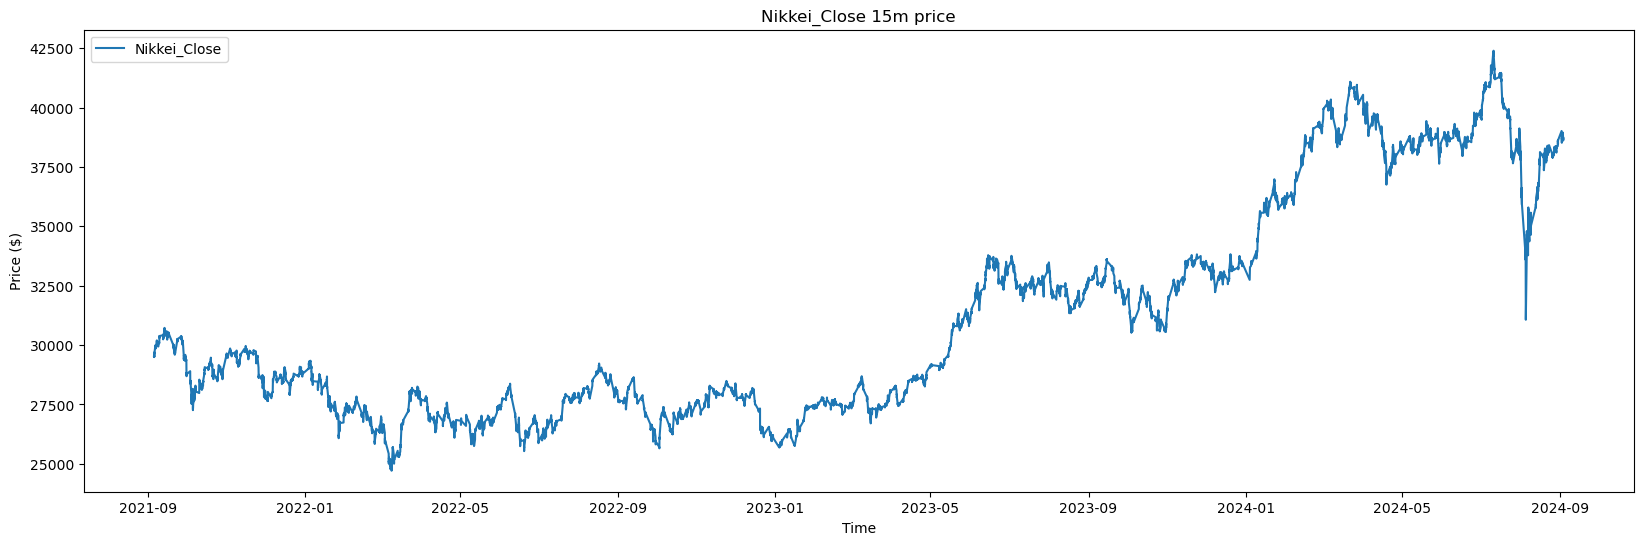


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [64]:
exploratory_feature_analysis(df_Nikkei)

##### - Aplicación de la función al dataset del índice __Nasdaq__

DataFrame (primeras filas):
                     Nasdaq_Close
DateTime                         
2021-09-07 13:30:00  15654.545898
2021-09-07 13:45:00  15641.947266
2021-09-07 14:00:00  15623.125977
2021-09-07 14:15:00  15634.366211
2021-09-07 14:30:00  15661.574219
...                           ...
2024-09-03 18:45:00  18997.591797
2024-09-03 19:00:00  19006.039062
2024-09-03 19:15:00  18986.449219
2024-09-03 19:30:00     18930.125
2024-09-03 19:45:00  18960.501953

[20169 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-07 13:30:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-07 13:45:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 20169  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0      ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Nasdaq_Close     │   0 │      0 │   14810 │   2484 │   10470 │  12610 │  14850 │  16370 │  20670 │ ▆▆▇▅▅▂  │  │
│ └──────────────────┴─────┴────────┴─────────┴────────┴─────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


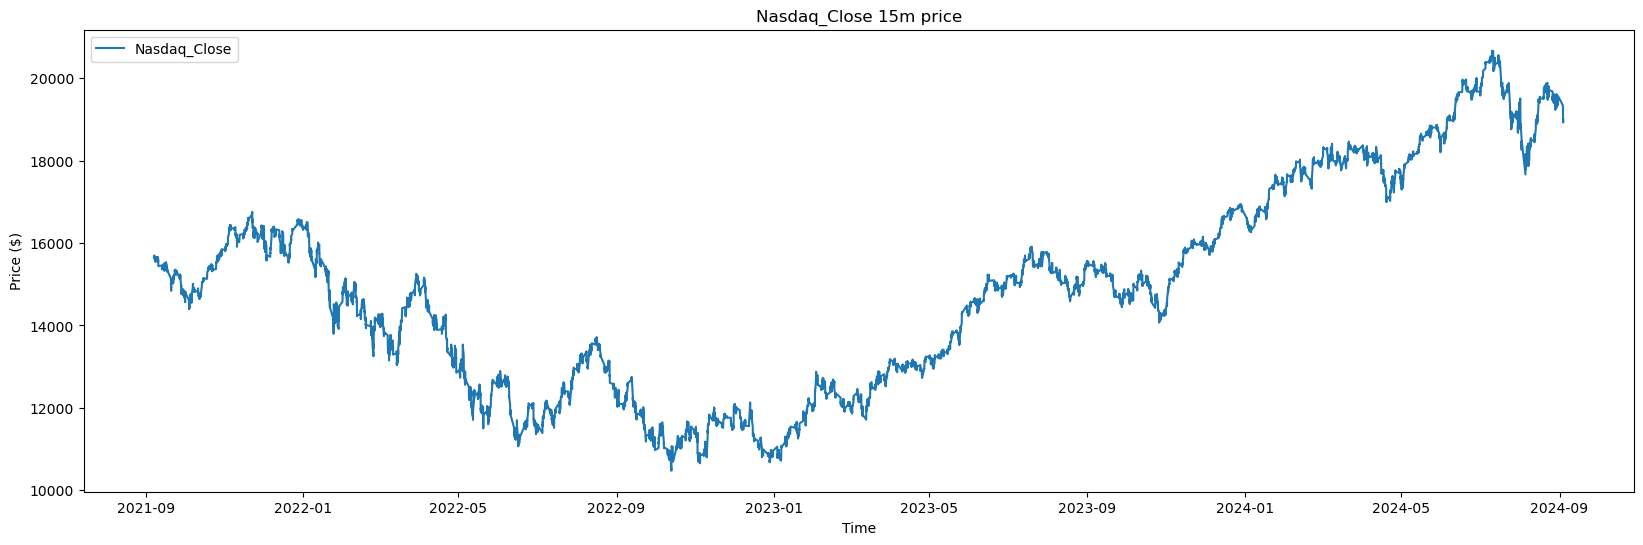


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [67]:
exploratory_feature_analysis(df_Nasdaq)

##### - Aplicación de la función al dataset del índice __IBEX-35__

DataFrame (primeras filas):
                     IBEX35_Close
DateTime                         
2021-09-06 07:00:00        8896.0
2021-09-06 07:15:00        8906.0
2021-09-06 07:30:00        8905.0
2021-09-06 07:45:00        8895.0
2021-09-06 08:00:00        8899.0
...                           ...
2024-09-03 14:30:00       11273.0
2024-09-03 14:45:00  11264.349609
2024-09-03 15:00:00  11278.849609
2024-09-03 15:15:00  11278.349609
2024-09-03 15:30:00  11279.200195

[26841 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-06 07:00:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-06 07:15:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 26841  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ IBEX35_Close      │    0 │      0 │   9235 │   1002 │   7196 │   8456 │   9108 │   9896 │  11460 │ ▁▇▇▅▂▃  │  │
│ └───────────────────┴──────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


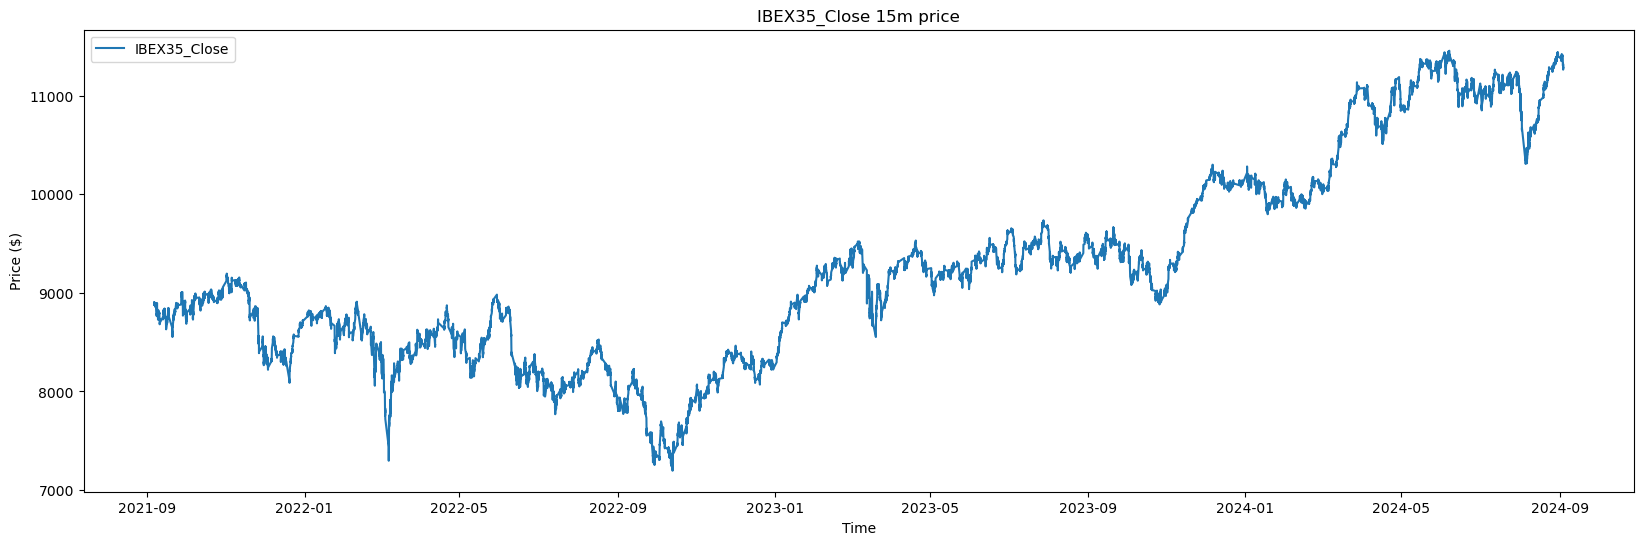


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [70]:
exploratory_feature_analysis(df_IBEX35)

##### - Aplicación de la función al dataset del índice __S&P 500__

DataFrame (primeras filas):
                     SP500_Close
DateTime                        
2021-09-15 13:30:00  4442.910156
2021-09-15 13:45:00       4453.5
2021-09-15 14:00:00  4446.399902
2021-09-15 14:15:00  4447.290039
2021-09-15 14:30:00  4446.899902
...                          ...
2024-09-13 18:45:00  5620.930176
2024-09-13 19:00:00  5620.209961
2024-09-13 19:15:00  5624.350098
2024-09-13 19:30:00  5624.759766
2024-09-13 19:45:00   5626.02002

[19543 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-15 13:30:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-15 13:45:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 19543  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ mean   ┃ sd       ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ SP500_Close      │    0 │      0 │   4474 │    509.3 │   3500 │   4085 │   4402 │   4735 │  5667 │ ▂▇▇▃▃▃  │  │
│ └──────────────────┴──────┴────────┴────────┴──────────┴────────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


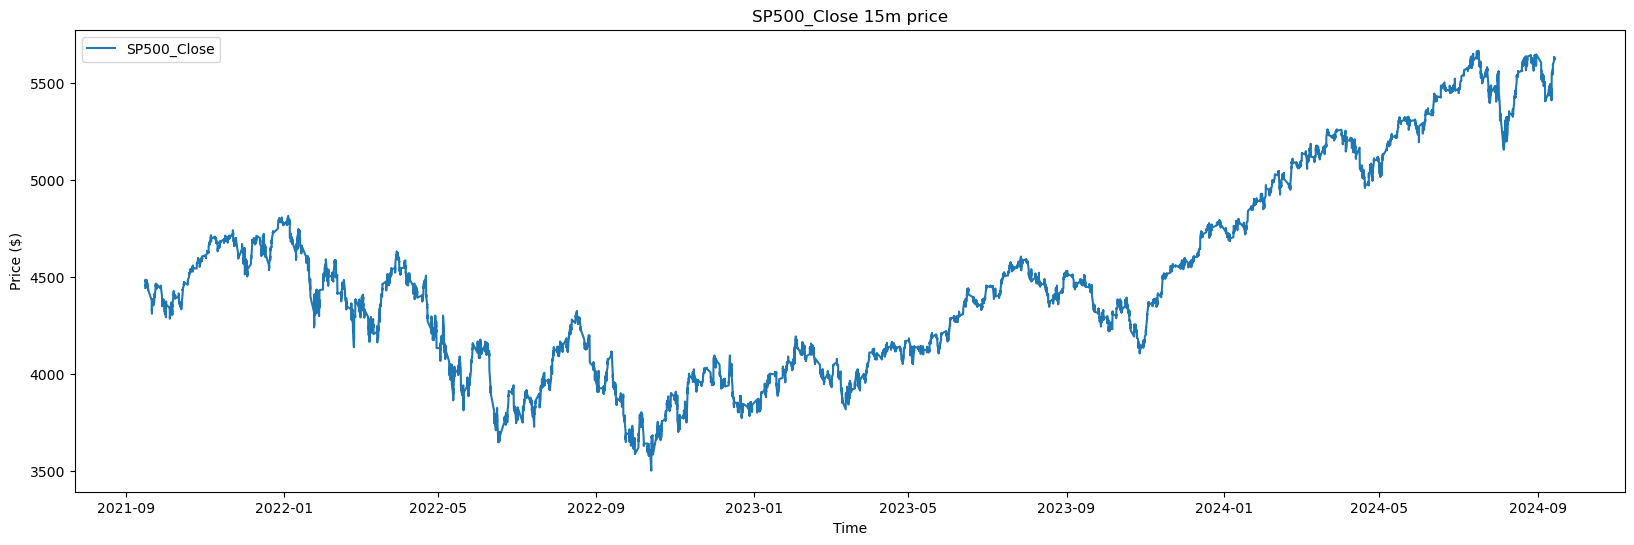


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [73]:
exploratory_feature_analysis(df_SP500)

##### - Aplicación de la función al dataset del índice __EuroStoxx 50__

DataFrame (primeras filas):
                    STOXX50_Close
DateTime                         
2021-09-06 07:00:00   4222.850098
2021-09-06 07:15:00   4231.450195
2021-09-06 07:30:00   4235.049805
2021-09-06 07:45:00   4232.160156
2021-09-06 08:00:00       4232.75
...                           ...
2024-09-03 14:30:00       4917.25
2024-09-03 14:45:00   4908.350098
2024-09-03 15:00:00       4913.75
2024-09-03 15:15:00   4913.549805
2024-09-03 15:30:00   4913.549805

[26863 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-06 07:00:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-06 07:15:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 26863  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %   ┃ mean   ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ STOXX50_Close      │    0 │      0 │   4225 │   448.1 │   3257 │   3907 │   4232 │  4420 │  5113 │ ▂▃▅▇▁▃  │  │
│ └────────────────────┴──────┴────────┴────────┴─────────┴────────┴────────┴────────┴───────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


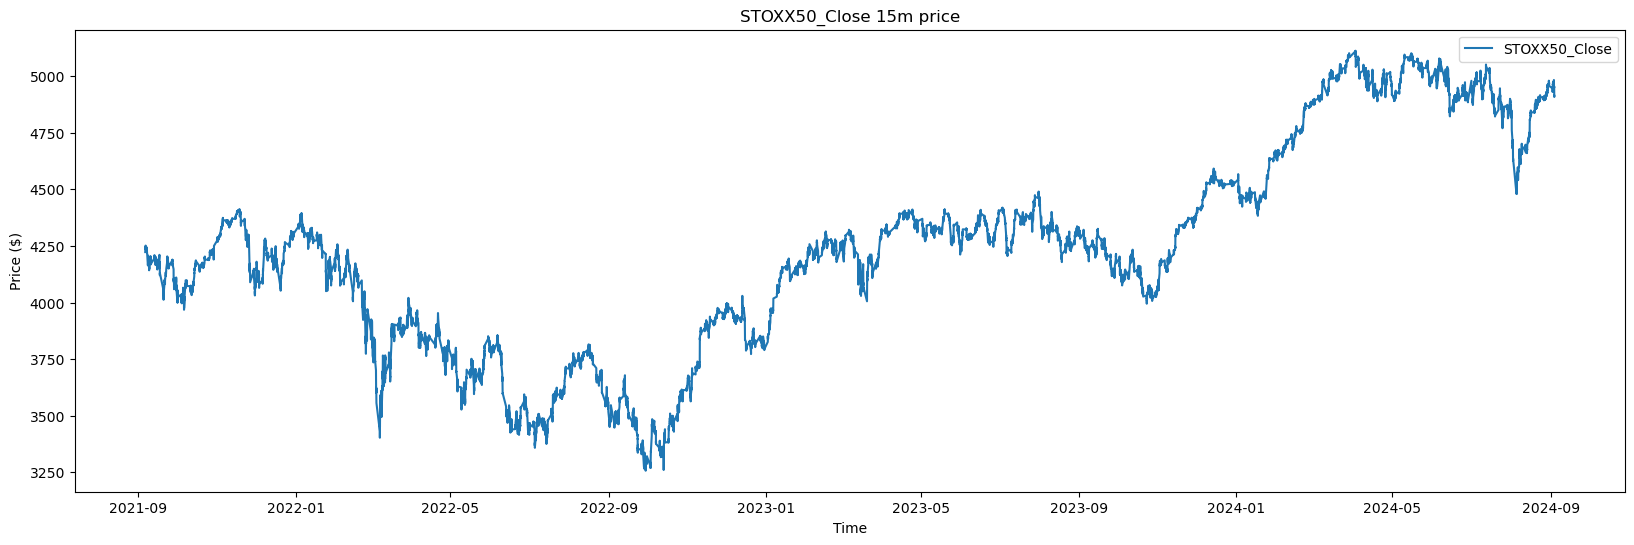


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [76]:
exploratory_feature_analysis(df_STOXX50)

##### - Aplicación de la función al dataset del índice __Dow Jones__

DataFrame (primeras filas):
                    DowJones_Close
DateTime                          
2021-09-07 13:30:00   35198.910156
2021-09-07 13:45:00       35172.75
2021-09-07 14:00:00   35106.308594
2021-09-07 14:15:00   35107.808594
2021-09-07 14:30:00   35091.269531
...                            ...
2024-09-03 19:15:00   40964.351562
2024-09-03 19:30:00   40850.738281
2024-09-03 19:45:00   40939.601562
2024-09-03 20:00:00   40936.929688
2024-09-03 20:15:00   40936.929688

[20321 rows x 1 columns]

--------------------------------------------------

Fecha de inicio del dataset: 2021-09-07 13:30:00

--------------------------------------------------

Comprobación de intervalos de 15 minutos:
La frecuencia de 15 minutos comienza a partir del: 2021-09-07 13:45:00

--------------------------------------------------

Datos estadísticos del dataset:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 20321  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA  ┃ NA %   ┃ mean    ┃ sd    ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ DowJones_Close     │   0 │      0 │   34970 │  2693 │  28710 │  33210 │  34380 │  36480 │  41570 │ ▁▃▇▃▃▁  │  │
│ └────────────────────┴─────┴────────┴─────────┴───────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯


--------------------------------------------------

Representación gráfica de la cotización del índice:


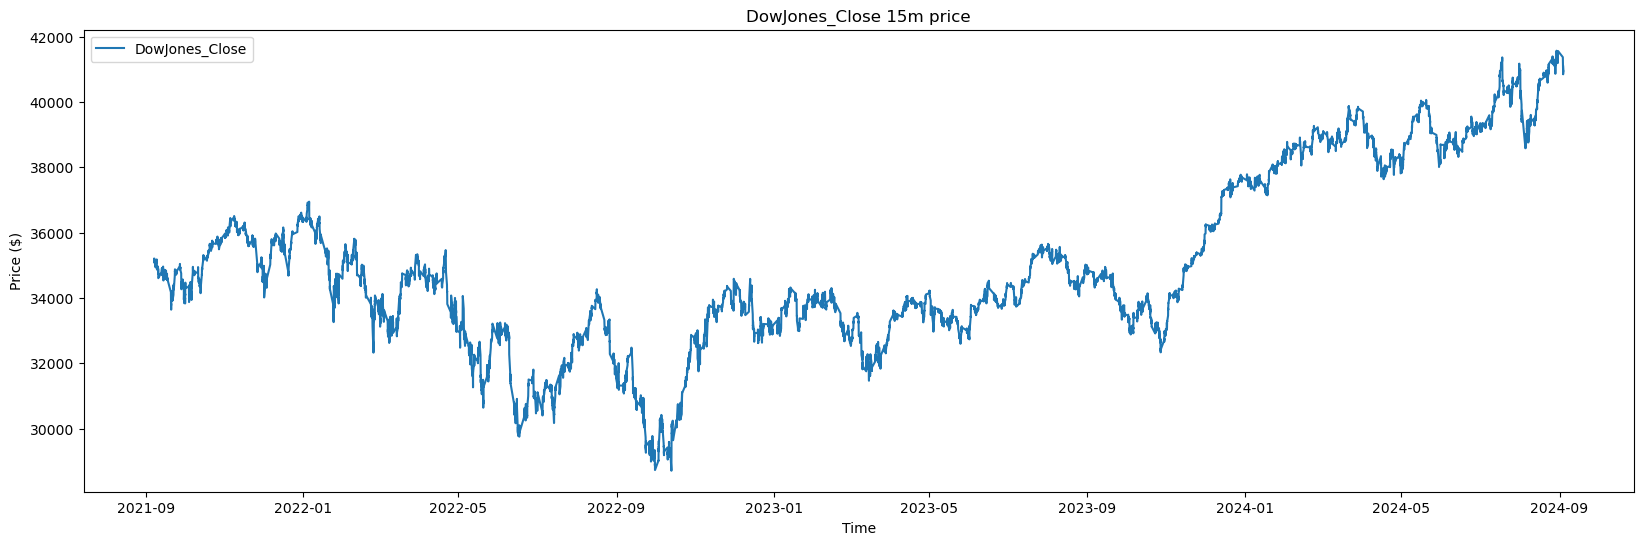


--------------------------------------------------

El índice no tiene valores duplicados.

--------------------------------------------------

No hay índices duplicados.

--------------------------------------------------



In [79]:
exploratory_feature_analysis(df_DowJones)

__Conclusión preliminar__:

- Ningún dataset presenta valores nulos.  
- Las fechas están distribuidas en intervalos de 15 minutos.  
- Ninguna de estas fechas está repetida en ninguno de los datasets. 

Ahora bien, las series empiezan en fechas distintas. Las que comienzan en fechas más tempranas son el DAX, el IBEX35 y el Eurostoxx 50: el día 06/09/21 a las 07:00:00 horas UTC, que en nuestro huso horario corresponde a las 09:00 horas de la mañana, cuando las bolsas europeas abren la sesión ordinaria. La serie que comienza más tardíamente corresponde al S&P 500: el día 15/09/21 a las 13:30:00 horas UTC, que en nuestro huso horario corresponde a las 15:30 h., hora a la que, efectivamente, las bolsas estadounidensen inician la sesión ordinaria. 

Dado que nuestra intención es crear un dataset fusionado que incluya todas las variables explicativas, tomaremos como momento temporal inicial la primera fecha de cotización del S&P 500, esto es, el día 15/09/21 a las 13:30:00. 
Por otro lado, la fecha final del dataset será el 31/12/23 23:45:00 h. Puesto que dejaremos el resto de cotizaciones hasta la fecha actual para realizar un *backtesting* del algoritmo de trading.

In [83]:
# Redefinimos todos los datasets, de modo que el primer registro empiece el 15/09/21 a las 13:30:00 h y el último acabe el 31/12/23  a las 23:45:00
df_crypto_redux = df_crypto.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_bitcoin_redux = df_bitcoin.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_DAX_redux = df_DAX.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_Nikkei_redux = df_Nikkei.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_DowJones_redux = df_DowJones.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_IBEX35_redux = df_IBEX35.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_Nasdaq_redux = df_Nasdaq.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_SP500_redux = df_SP500.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]
df_STOXX50_redux = df_STOXX50.loc["2021-09-15 13:30:00":"2023-12-31 23:45:00"]

In [85]:
print(df_crypto_redux.index[0])
print(df_bitcoin_redux.index[0])
print(df_DAX_redux.index[0])
print(df_Nikkei_redux.index[0])
print(df_DowJones_redux.index[0])
print(df_IBEX35_redux.index[0])
print(df_Nasdaq_redux.index[0])
print(df_SP500_redux.index[0])
print(df_STOXX50_redux.index[0])

2021-09-15 13:30:00
2021-09-15 13:30:00
2021-09-15 13:30:00
2021-09-16 00:00:00
2021-09-15 13:30:00
2021-09-15 13:30:00
2021-09-15 13:30:00
2021-09-15 13:30:00
2021-09-15 13:30:00


Observamos que el dataset del Nikkei ha cortado los registros a partir del 16/09/2021 a las 00:00:00 h. Esto es debido a que la sesión bursátil en Tokio finaliza a las 06:00:00 UTC, por lo que no existen cotizaciones en ese lapso temporal del día. Cuando fusionemos los datasets comprobaremos que se generarán una gran cantidad de valores perdidos, pues esta problemática existe también entre todos los índices correspondientes a mercados bursátiles que se desarrollan en distintos continentes.

Una vez seleccionado el intervalo de fechas con los que vamos a trabar, aplicamos la función *time_difference* al dataset de la criptomoneda cuyo valor ha de predecirse y al del Bitcoin, para asegurarnos de que todos los intervalos temporales son de 15 minutos.

In [89]:
# Aplicación de la función al dataset de la primera, cuya serie empieza el 2021-09-15 13:30:00
time_difference(df_crypto_redux)

La frecuencia de 15 minutos comienza a partir del: 2021-09-15 13:45:00


In [91]:
# Aplicación de la función al dataset de la segunda, cuya serie empieza el 2021-09-15 13:30:00
time_difference(df_crypto_redux)

La frecuencia de 15 minutos comienza a partir del: 2021-09-15 13:45:00


Todas las frecuencias de ambos dataset son de 15 minutos.

Antes de fusionar los datasets, los deredifimos para quedarnos únicamente con la columna del precio de cierre

In [95]:
# Eliminamos la columna usada para comprobar las frecuencias de cotización
df_crypto_redux = df_crypto_redux.iloc[:, [0]]
df_bitcoin_redux = df_bitcoin_redux.iloc[:, [0]]
df_DAX_redux = df_DAX_redux.iloc[:, [0]]
df_Nikkei_redux = df_Nikkei_redux.iloc[:, [0]]
df_DowJones_redux = df_DowJones_redux.iloc[:, [0]]
df_IBEX35_redux = df_IBEX35_redux.iloc[:, [0]]
df_Nasdaq_redux = df_Nasdaq_redux.iloc[:, [0]]
df_SP500_redux = df_SP500_redux.iloc[:, [0]]
df_STOXX50_redux = df_STOXX50_redux.iloc[:, [0]]

In [97]:
# Fusión de los datasets de las variables predictoras en función de la columna "DateTime", incluyendo el dataset del Bitcoin, que también usaremos como variable predictora.
df_predictors = (
    df_bitcoin_redux.merge(df_DAX_redux, how="left", on="DateTime")
    .merge(df_Nikkei_redux, how="left", on="DateTime")
    .merge(df_Nasdaq_redux, how="left", on="DateTime")
    .merge(df_IBEX35_redux, how="left", on="DateTime")
    .merge(df_SP500_redux, how="left", on="DateTime")
    .merge(df_STOXX50_redux, how="left", on="DateTime")
    .merge(df_DowJones_redux, how="left", on="DateTime")
)

In [99]:
df_predictors

,XBTUSD_Close,DAX_Close,Nikkei_Close,Nasdaq_Close,IBEX35_Close,SP500_Close,STOXX50_Close,DowJones_Close
DateTime,,,,,,,,
2021-09-15 13:30:00,47747.8,15665.75,NaN,15345.014648,8670.5,4442.910156,4157.450195,34593.839844
2021-09-15 13:45:00,47789.1,15684.25,NaN,15364.00293,8682.5,4453.5,4162.450195,34685.621094
2021-09-15 14:00:00,47864.0,15634.25,NaN,15324.483398,8646.5,4446.399902,4151.350098,34640.328125
2021-09-15 14:15:00,47804.8,15638.25,NaN,15333.924805,8659.5,4447.290039,4150.549805,34628.269531
2021-09-15 14:30:00,47714.7,15618.25,NaN,15352.859375,8646.5,4446.899902,4146.950195,34592.949219
...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,42255.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:00:00,42237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:15:00,42183.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Comprobación de valores faltantes en el dataset de variable explicativas.
skim(df_predictors)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 80340  │ │ float64     │ 8     │                                                          │
│ │ Number of columns │ 8      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name       ┃ NA     ┃ NA %   ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ XBTUSD_Close      │      0 │      0 │  31820 │  11870 │  15630 │  22490 │  28590 │  40200 │ 68700 │ ▇▇▃▃▁▁ │  │
│ │ DAX_Close         │  59811 │  74.45 │  14880 │   1144 │  11880 │  14040 │  15220 │  15800 │ 16990 │ ▁▃▃▃▇▂ │  │
│ │ Nikkei_Close      │  66708 │  83.03 │  28980 │   2353 │  24710 │  27290 │  28140 │  31060 │ 33820 │ ▁▇▆▂▂▃ │  │
│ │ Nasdaq_Close      │  64837 │   80.7 │  13770 │   1704 │  10470 │  12160 │  13940 │  15200 │ 16950 │ ▃▇▅▅▇▃ │  │
│ │ IBEX35_Close      │  59837 │  74.48 │   8797 │  614.3 │   7196 │   8321 │   8816 │   9278 │ 10300 │ ▁▅▇▇▆▁ │  │
│ │ SP500_Close       │  65397 │   81.4 │   4240 │    294 │   3500 │   3992 │   4246 │   4481 │  4815 │ ▁▅▇▆▇▃ │  │
│ │ STOXX50_Close     │  59812 │  74.45 │   4037 │    312 │   3257 │   3798 │   4141 │   4290 │  4592 │ ▁▂▃▃▇▂ │  │
│ │ DowJones_Close    │  64816 │  80.68 │  33750 │   1637 │  28710 │  32910 │  33830 │  34790 │ 37770 │ ▁▂▅▇▅▁ │  │
│ └───────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

__Problemática__: el número de valores perdidos es necesariamente muy elevado proporcionalmente, debido a que el mercado de criptomonedas, al igual que el mercado de *forex* (tipos de cambio), funcionan de forma ininterrumpida las 24 horas del día. Al contrario, los índices bursátiles, dependientes de la cotización de la cesta de valores que los conforman, van de la mano del funcionamiento del mercado bursatil en cuestión, que se mantiene abierto un pequeño número de horas al cabo de un día, y cierra los sábados y los domingos.

__Decisión__: aunque somos conscientes de que introduce un <u>sesgo relevante</u> en el entrenamiento del modelo, optamos por alimentar los valores faltantes con el último valor disponible.  

__Justificación__: consideramos que esta elección, aunque indeseable desde un punto de vista estadístico, está fundada en la experiencia y la observación. En el sentido en que la cotización de cierre de determinado índice tiende a ejercer una influencia continua en el tiempo sobre las cotizaciones del resto de los mercados abiertos, hasta que dicho índice vuelve a cotizar al día siguiente y, por tanto, a transmitir nueva información a los agentes. A menos, vale reconocer, que los agentes reciban información relevante y fidedigna de otra fuente que contrarrestre el efecto que la última cotización del índice produjo. 

A continuación, fusionamos el dataset de la criptomoneda cuyas cotizaciones han de ser predichas con el dataset de variables predictoras

In [105]:
# Fusión del dataset de la criptomoneda y de las variables predictoras en función del primero.
df_merged = (
    df_crypto_redux
    .merge(df_predictors, how="left", on="DateTime")
)

df_merged

,LINKUSD_Close,XBTUSD_Close,DAX_Close,Nikkei_Close,Nasdaq_Close,IBEX35_Close,SP500_Close,STOXX50_Close,DowJones_Close
DateTime,,,,,,,,,
2021-09-15 13:30:00,30.94851,47747.8,15665.75,NaN,15345.014648,8670.5,4442.910156,4157.450195,34593.839844
2021-09-15 13:45:00,30.92581,47789.1,15684.25,NaN,15364.00293,8682.5,4453.5,4162.450195,34685.621094
2021-09-15 14:00:00,30.79399,47864.0,15634.25,NaN,15324.483398,8646.5,4446.399902,4151.350098,34640.328125
2021-09-15 14:15:00,30.58698,47804.8,15638.25,NaN,15333.924805,8659.5,4447.290039,4150.549805,34628.269531
2021-09-15 14:30:00,30.47352,47714.7,15618.25,NaN,15352.859375,8646.5,4446.899902,4146.950195,34592.949219
...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,14.90631,42255.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:00:00,14.95455,42237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:15:00,14.91053,42183.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
skim(df_merged)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 79334  │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 9      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name       ┃ NA     ┃ NA %   ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ LINKUSD_Close     │      0 │      0 │  11.48 │  7.093 │  4.988 │  6.788 │    7.5 │  14.95 │ 38.14 │ ▇▂▁▁▁  │  │
│ │ XBTUSD_Close      │      0 │      0 │  31880 │  11920 │  15630 │  22460 │  28710 │  40400 │ 68700 │ ▇▇▃▃▁▁ │  │
│ │ DAX_Close         │  58975 │  74.34 │  14870 │   1145 │  11880 │  14040 │  15220 │  15790 │ 16990 │ ▁▃▃▃▇▂ │  │
│ │ Nikkei_Close      │  65847 │     83 │  28980 │   2352 │  24710 │  27280 │  28140 │  31040 │ 33820 │ ▁▇▆▂▂▃ │  │
│ │ Nasdaq_Close      │  63884 │  80.53 │  13770 │   1706 │  10470 │  12150 │  13940 │  15200 │ 16950 │ ▃▇▅▅▇▃ │  │
│ │ IBEX35_Close      │  59001 │  74.37 │   8795 │    615 │   7196 │   8320 │   8814 │   9277 │ 10300 │ ▁▅▇▇▆▁ │  │
│ │ SP500_Close       │  64442 │  81.23 │   4240 │  294.3 │   3500 │   3992 │   4246 │   4481 │  4815 │ ▁▅▇▆▇▃ │  │
│ │ STOXX50_Close     │  58976 │  74.34 │   4036 │  312.3 │   3257 │   3796 │   4140 │   4290 │  4592 │ ▁▂▃▃▇▂ │  │
│ │ DowJones_Close    │  63863 │   80.5 │  33750 │   1639 │  28710 │  32910 │  33830 │  34800 │ 37770 │ ▁▂▅▇▅▁ │  │
│ └───────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Tomamos la decisión de rellenar los valores nulos con el último valor existente.

In [114]:
# Bucle para rellenar los valores faltantes en las variables, replicando el valor anterior disponible
for col in df_merged.columns:
    df_merged[col] = df_merged[col].fillna(method = "ffill")

In [116]:
skim(df_merged)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 79334  │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 9      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ LINKUSD_Close     │   0 │      0 │   11.48 │  7.093 │  4.988 │  6.788 │    7.5 │  14.95 │  38.14 │  ▇▂▁▁▁  │  │
│ │ XBTUSD_Close      │   0 │      0 │   31880 │  11920 │  15630 │  22460 │  28710 │  40400 │  68700 │ ▇▇▃▃▁▁  │  │
│ │ DAX_Close         │   0 │      0 │   14880 │   1146 │  11880 │  14040 │  15220 │  15810 │  16990 │ ▁▃▃▅▇▂  │  │
│ │ Nikkei_Close      │  42 │   0.05 │   28960 │   2335 │  24710 │  27220 │  28140 │  30990 │  33820 │ ▁▇▇▁▂▃  │  │
│ │ Nasdaq_Close      │   0 │      0 │   13770 │   1712 │  10470 │  12170 │  13940 │  15200 │  16950 │ ▃▇▅▅▇▃  │  │
│ │ IBEX35_Close      │   0 │      0 │    8799 │    619 │   7196 │   8322 │   8800 │   9284 │  10300 │ ▁▅▇▇▆▁  │  │
│ │ SP500_Close       │   0 │      0 │    4242 │  295.1 │   3500 │   3994 │   4268 │   4479 │   4815 │ ▁▅▇▅▇▃  │  │
│ │ STOXX50_Close     │   0 │      0 │    4039 │  312.8 │   3257 │   3803 │   4145 │   4293 │   4592 │ ▁▂▃▃▇▂  │  │
│ │ DowJones_Close    │   0 │      0 │   33760 │   1648 │  28710 │  32920 │  33870 │  34790 │  37770 │ ▁▂▃▇▅▁  │  │
│ └───────────────────┴─────┴────────┴─────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Como era de esperar, quedan valores faltantes en la variable del Nikkei, es decir, el del índice cuya cotización empieza de madrugada. Estos registros corresponden a las horas de la tarde del día 15/09/21. Por tanto, aplicamos un *backward fill* para rellenarlos.

In [119]:
# Bucle para rellenar los valores faltantes en la variable "Nikkei_Close"
for col in df_merged.columns:
    df_merged[col] = df_merged[col].fillna(method = "bfill")

Comprobamos nuevamente si ahora los valores del sábado 30-06-18 están rellenos

In [122]:
skim(df_merged)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 79334  │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 9      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ LINKUSD_Close     │   0 │      0 │   11.48 │  7.093 │  4.988 │  6.788 │    7.5 │  14.95 │  38.14 │  ▇▂▁▁▁  │  │
│ │ XBTUSD_Close      │   0 │      0 │   31880 │  11920 │  15630 │  22460 │  28710 │  40400 │  68700 │ ▇▇▃▃▁▁  │  │
│ │ DAX_Close         │   0 │      0 │   14880 │   1146 │  11880 │  14040 │  15220 │  15810 │  16990 │ ▁▃▃▅▇▂  │  │
│ │ Nikkei_Close      │   0 │      0 │   28960 │   2335 │  24710 │  27220 │  28140 │  30990 │  33820 │ ▁▇▇▂▂▃  │  │
│ │ Nasdaq_Close      │   0 │      0 │   13770 │   1712 │  10470 │  12170 │  13940 │  15200 │  16950 │ ▃▇▅▅▇▃  │  │
│ │ IBEX35_Close      │   0 │      0 │    8799 │    619 │   7196 │   8322 │   8800 │   9284 │  10300 │ ▁▅▇▇▆▁  │  │
│ │ SP500_Close       │   0 │      0 │    4242 │  295.1 │   3500 │   3994 │   4268 │   4479 │   4815 │ ▁▅▇▅▇▃  │  │
│ │ STOXX50_Close     │   0 │      0 │    4039 │  312.8 │   3257 │   3803 │   4145 │   4293 │   4592 │ ▁▂▃▃▇▂  │  │
│ │ DowJones_Close    │   0 │      0 │   33760 │   1648 │  28710 │  32920 │  33870 │  34790 │  37770 │ ▁▂▃▇▅▁  │  │
│ └───────────────────┴─────┴────────┴─────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

El dataframe ha quedado libre de valores faltantes, por lo que vamos a proceder a entrenar distintos modelos.

#### Entrenamiento de un modelo de regresión lineal múltiple

Para el entrenamiento de los modelos, nuestra variable objetivo será el precio de cierre de la criptomoneda y utilizaremos los precios de cierre en intervalos de 15 minutos de las variables predictoras. Dado que nuestra intención es desarrollar modelos capaces de predecir la cotización de la criptomoneda en el cuarto de hora siguiente, desplazamos la serie de la criptomoneda 15 minutos atrás en el tiempo.

In [124]:
# Desplazamos hacia atrás un intrervalo de 15 minutos la serie temporal de la criptomoneda
df_merged["LINKUSD_Close"] = (
    df_merged["LINKUSD_Close"]
    .shift(-1)
)
# Eliminar la última fila, que contiene un valor nulo en el último índice de la serie de la criptomoneda
df_for_regression = df_merged.iloc[:-1]
df_for_regression 

,LINKUSD_Close,XBTUSD_Close,DAX_Close,Nikkei_Close,Nasdaq_Close,IBEX35_Close,SP500_Close,STOXX50_Close,DowJones_Close
DateTime,,,,,,,,,
2021-09-15 13:30:00,30.92581,47747.8,15665.750000,30572.500000,15345.014648,8670.500000,4442.910156,4157.450195,34593.839844
2021-09-15 13:45:00,30.79399,47789.1,15684.250000,30572.500000,15364.002930,8682.500000,4453.500000,4162.450195,34685.621094
2021-09-15 14:00:00,30.58698,47864.0,15634.250000,30572.500000,15324.483398,8646.500000,4446.399902,4151.350098,34640.328125
2021-09-15 14:15:00,30.47352,47804.8,15638.250000,30572.500000,15333.924805,8659.500000,4447.290039,4150.549805,34628.269531
2021-09-15 14:30:00,30.55160,47714.7,15618.250000,30572.500000,15352.859375,8646.500000,4446.899902,4146.950195,34592.949219
...,...,...,...,...,...,...,...,...,...
2023-12-31 22:30:00,14.90631,42478.8,16751.640625,33464.171875,16825.931641,10102.099609,4769.830078,4521.649902,37689.539062
2023-12-31 22:45:00,14.95455,42255.6,16751.640625,33464.171875,16825.931641,10102.099609,4769.830078,4521.649902,37689.539062
2023-12-31 23:00:00,14.91053,42237.0,16751.640625,33464.171875,16825.931641,10102.099609,4769.830078,4521.649902,37689.539062


En primer lugar, emplearemos la técnica <u>*Sequential feature selection*</u> sobre la base del coeficiente de determinación (R2) de una regresión lineal, al objeto de obtener orientación sobre la importancia de las variables en este sentido.

In [127]:
# Definición de las variables
X = df_for_regression.drop(df_for_regression.columns[0], axis = 1)
y = df_for_regression[df_for_regression.columns[0]]

In [129]:
# Separación del dataset en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [131]:
# Definición del escalador
sc_X = StandardScaler()
# Escalado de los valores de las variables predictoras
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [133]:
# Conversión en dataframes para la aplicación del SFS
X_train_df = pd.DataFrame(X_train_sc, columns = X.columns)
X_test_df = pd.DataFrame(X_test_sc, columns = X.columns)

In [135]:
# Creación de un nuevo dataset que contendrá la relación variables predictoras con mayor coeficiente de terminación
dataset_seleccion = pd.DataFrame()

# Bucle para iterar sobre sobre las columnas del dataframe y crear posibles conjuntos de variables predictoras
for i in range(1, len(X_train_df.columns)):
    # Definición de las características del Sequential Feature Selection
    sbs = SFS(LinearRegression(),k_features=i,forward=False,floating=False)
    # Entrenamiento del selector
    sbs.fit(np.array(X_train_sc), y_train)
    # Extracción de las variables
    sbs.k_feature_names_
    # Creación y entrenamiento de un modelo de regresión lineal con las variables seleccionadas en cada iteración
    regression = LinearRegression()
    regression.fit(X_train_df[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]], y_train)
    # Predicción del conjunto de test
    y_pred = regression.predict(X_test_df[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]])
    # Cálculo del coeficiente de determinación del conjunto de test
    r2 = r2_score(y_pred = y_pred, y_true = y_test)
    # Incorporación de los resultados, en forma de dataframe, a la lista creada anteriormente
    dataset_seleccion = pd.concat([dataset_seleccion,pd.DataFrame({"variables":[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]],"r2": r2})],ignore_index = True)

In [136]:
# Ordenación del dataframe obtenido, según el valor del coeficiente de feterminación, de mayor a menor
sorted_dataset_seleccion = dataset_seleccion.sort_values(by = "r2", ascending = False, ignore_index = True)

In [137]:
sorted_dataset_seleccion

,variables,r2
0,"[XBTUSD_Close, Nikkei_Close, Nasdaq_Close, IBE...",0.904247
1,"[XBTUSD_Close, Nikkei_Close, Nasdaq_Close, IBE...",0.904049
2,"[XBTUSD_Close, Nasdaq_Close, IBEX35_Close, SP5...",0.903633
3,"[XBTUSD_Close, IBEX35_Close, SP500_Close, DowJ...",0.894405
4,"[XBTUSD_Close, IBEX35_Close, DowJones_Close]",0.884327
5,"[XBTUSD_Close, IBEX35_Close]",0.874840
6,[XBTUSD_Close],0.844163


Escogemos la lista nº4, con solo tres variables que arrojan un r2 del 88,43%, y representamos gráficamente la relación de cada uno con la criptomoneda.

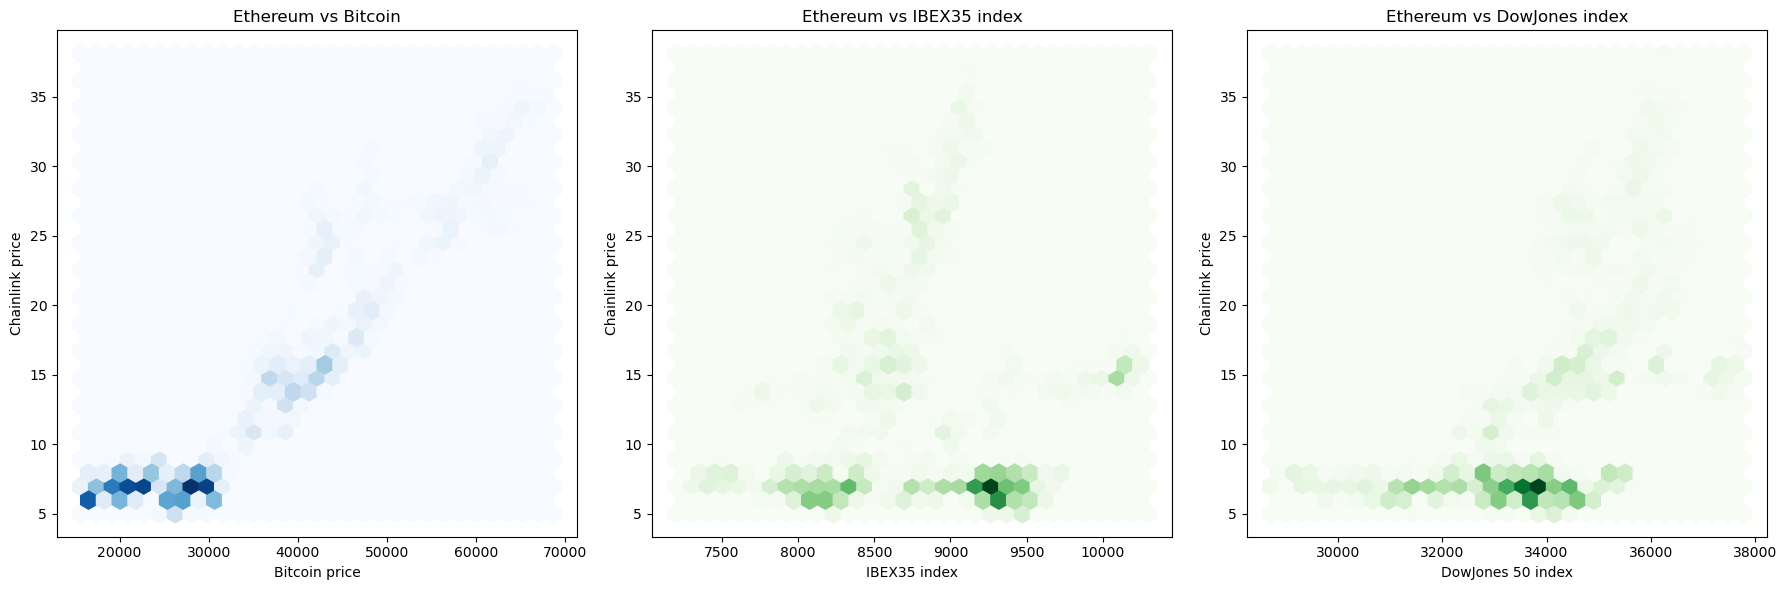

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primer hexbin plot
axes[0].hexbin(df_for_regression["XBTUSD_Close"], df_for_regression["LINKUSD_Close"], gridsize=30, cmap="Blues")
axes[0].set_title("Ethereum vs Bitcoin")
axes[0].set_xlabel("Bitcoin price")
axes[0].set_ylabel("Chainlink price")

# Segundo hexbin plot
axes[1].hexbin(df_for_regression["IBEX35_Close"], df_for_regression["LINKUSD_Close"], gridsize=30, cmap="Greens")
axes[1].set_title("Ethereum vs IBEX35 index")
axes[1].set_xlabel("IBEX35 index")
axes[1].set_ylabel("Chainlink price")

# Segundo hexbin plot
axes[2].hexbin(df_for_regression["DowJones_Close"], df_for_regression["LINKUSD_Close"], gridsize=30, cmap="Greens")
axes[2].set_title("Ethereum vs DowJones index")
axes[2].set_xlabel("DowJones 50 index")
axes[2].set_ylabel("Chainlink price")

plt.tight_layout()
plt.show()

Parece haber una relación aproximadamente lineal con el Bitcoin, si atendemos principalmente a la acumulación de puntos en el entorno de los 15.000 USD-30.000 USD por cada Bitcoin y 5 USD-9 USD por cada token de Chainlink. La relación con el Ibex 35 y con el Dow Jones es muchos menos clara, por más que también destacan determinados intervalos que asemejan linealidad. Visualmente no sería descartable la existencia de cierta relación polinómica, al menos con Bitcoin.

Estudio de la correlación entre las variables predictoras (<u>multicolinealidad</u>)

<Axes: >

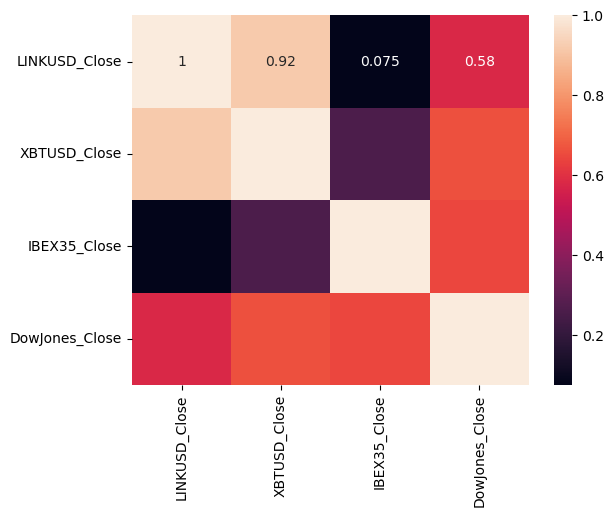

In [152]:
# Creación de un dataset reducido que contenga únicamente las cuatro variables
df_for_regression_redux = df_for_regression[
    [df_merged.columns[0], "XBTUSD_Close", "IBEX35_Close", "DowJones_Close"]
]

# Representación de un mapa de calor
corr_matrix = df_for_regression_redux.corr()
sns.heatmap(corr_matrix, annot=True)

__Problemática__: Podría existir mulicolinealidad, por un lado, entre el IBEX-35 y el Dow Jones; por otro, entre el Dow Jones y el Bitcoin. 
(i) La primera relación estaría sustentada en la influencia que las perspectivas sobre la economía estadounidense ejerce sobre el resto de indicadores, ya que el Dow Jones recoge la cotización de los 30 principales valores de la Bolsa de Nueva York. 
(ii) La segunda relación no está clara. La analizamos en otro lugar, cuando entrenamos modelos predictivos para la cotización de Bitcoin.   

__Decisión__: optamos por mantener las tres variables predictivas, pues añaden información adicional al tratarse de un índices que tratan de informar sobre compañías distintas que son relativamente independientes entre sí.

#### Entrenamiento de un modelo de regresión lineal

In [155]:
# Definición de las variables
X = df_for_regression_redux.drop([df_for_regression_redux.columns[0], df_for_regression_redux.columns[-1]], axis = 1)
y = df_for_regression_redux[df_for_regression_redux.columns[0]]

In [157]:
# Separación del dataset en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [159]:
# Definición del escalador
sc_X = StandardScaler()
# Escalado de los valores de las variables predictoras
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [161]:
# Definición del modelo de regresión lineal
lin_model = LinearRegression()
# Entrenamiento del modelo de regresión
lin_model.fit(X_train_sc, y_train)

LinearRegression()

In [163]:
# Evaluación del modelo para el dataset de entrenamiento

y_train_predict = lin_model.predict(X_train_sc)

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_predict)
# Root Mean Square Error del modelo
rmse_train = mean_squared_error(y_train, y_train_predict, squared = False)
# R-squared Score del modelo
r2_train = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print("MSE is {}".format(mse_train))
print("RMSE is {}".format(rmse_train))
print("R2 score is {}".format(r2_train))
print("\n")

# Evaluación del modelo para el dataset de validación

y_test_predict = lin_model.predict(X_test_sc)

# Mean Squared Error
mse_test = mean_squared_error(y_test, y_test_predict)
# Root Mean Square Error del modelo
rmse_test = mean_squared_error(y_test, y_test_predict, squared = False)
# R-squared Score del modelo
r2_test = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print("MSE is {}".format(mse_test))
print("RMSE is {}".format(rmse_test))
print("R2 score is {}".format(r2_test))

The model performance for training set
--------------------------------------
MSE is 6.242670087995844
RMSE is 2.49853358752606
R2 score is 0.8767152191287736


The model performance for testing set
--------------------------------------
MSE is 6.197943480575955
RMSE is 2.489566926309866
R2 score is 0.8748397323023421


A continuación comprobaremosla bondad de ajuste del modelo de regresión mediante una serie de indicadores:

In [170]:
# Definición de las variables
X = df_for_regression_redux[["XBTUSD_Close", "IBEX35_Close", "DowJones_Close"]] 
y = df_for_regression_redux["LINKUSD_Close"] 

# Entrenamiento de un modelo de Mínimos Cuadrados Ordinarios con las variables seleccionadas
X = sm.add_constant(X) 
lr_model = sm.OLS(y, X).fit() 
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          LINKUSD_Close   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.041e+05
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:18:37   Log-Likelihood:            -1.8209e+05
No. Observations:               79333   AIC:                         3.642e+05
Df Residuals:                   79329   BIC:                         3.642e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.2200      0.216    -14.893      0.000      -3.644      -2.796
XBTUSD_Close       0.0005      1e-06    521.954      0.000       0.001       0.001
IBEX35_Close      -0.0030   1.89e-05   -159.291      0.000      -0.003      -0.003
DowJones_Close     0.0007   9.14e-06     79.427      0.000       0.001       0.001
==============================================================================
Omnibus:                     8028.072   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12529.475
Skew:                           0.751   Prob(JB):                         0.00
Kurtosis:                       4.239   Cond. No.                     1.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### <u>Comentario sobre los resultados obtenidos</u>

__MAE y RMSE__: presentan valores muy elevados. A nuestro juicio, un modelo de este tipo sería inconveniente.

**R2 y R2 ajustado**: como era de esperar tras la realización del Sequential Feature Selection, el valor obtenido para el primero es 88,5%, que en este caso es idéntico para el segundo.

**ANOVA**: obtenemos un valor elevado para el estadístico F, 2.041e +05, con una probabilidad muy cercana a cero, lo que implica probabilidad casi nula de que la explicabilidad de la varianza por parte del modelo venga dada por aleatoriedad. En consecuencia, rechazamos la hipótesis nula (h0) de que el modelo pueda prescindir de las tres variables independientes.

**Multicolinealidad**: es interesante destacar que, aunque podemos considerar que existe multicolinealidad entre las tres variables predictoras, las varianzas de sus coeficientes son muy pequeñas. <u>Una posibilidad sería crear una nueva variable independiente que sea una función de las tres</u>.

**T-Test y p-valor**: se observan p-valores muy cercanos a cero tanto para el intercepto como para las tres variables independientes, por lo que podemos rechazar la hipótesis nula (h0) de que las tres variables independientes no están correlacionadas con la variable dependiente. En consecuencia, mantenemos estas tres variables en modelo de regresión.

**Durbin-Watson**: obtenemos un valor muy cercano a cero, lo que implica que debemos rechazar la hipótesis nula de que los residuos no están correlacionados.

**Jarque-Bera y Prob(JB)**: los valores obtenidos indican muy elevada probabilidad de que los residuos no se distribuyan normalmente. Lo que queda confirmado por la gráfica de cuantiles (QQ-plot) más abajo:

Comprobación, mediante el empleo de un QQ-plot, de la normalidad o no de los errores: 

In [181]:
# Creación de una función para la graficación del qq-plot
def plot_qq(model):
    # Obtención de los residuos estandarizados
    model_norm_residuals=model.get_influence().resid_studentized_internal

    # Configuración del gráfico QQ
    QQ=ProbPlot(model_norm_residuals)
    # Creación del gráfico QQ
    fig=QQ.qqplot(line="45", alpha=0.5, lw=1)
    
    fig.set_figheight(8)
    fig.set_figwidth(12)

    fig.axes[0].set_title("Normal Q-Q")
    fig.axes[0].set_xlabel("Theoretical Quantiles")
    fig.axes[0].set_ylabel("Standardized Residuals")

    # Anotación de los residuos más extremos para el gráfico QQ
    abs_norm_resid=np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3=abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        fig.axes[0].annotate(i, xy=(QQ.theoretical_quantiles[r], model_norm_residuals[i]))

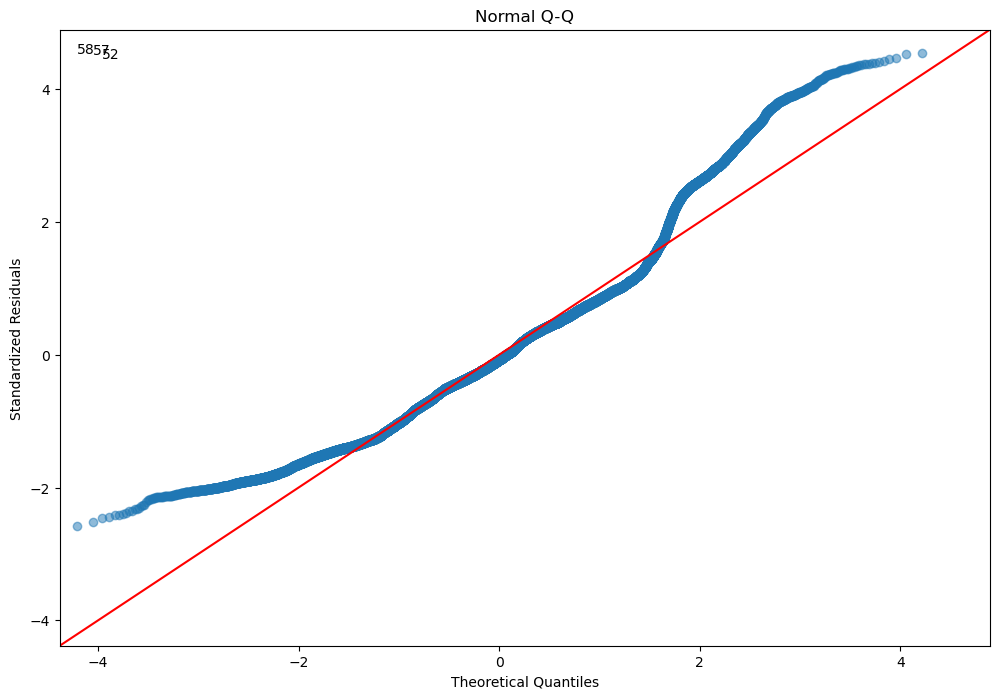

In [183]:
plot_qq(lr_model)

Desde un punto de vista visual, habida cuenta de las desviaciones existentes respecto del eje de 45 grados, no podríamos asegurar que los residus se distribuyen normalmente.

Aplicación del test de Shapiro-Wilk y Kolmogorov-Smirnov:

In [187]:
# Definición de una función para la aplicación de las pruebas de Shapiro-Wilk y de Kolmogorov-Smirnov
def Shapiro_Kolmogorov_tests (model):
    model_norm_residuals=model.get_influence().resid_studentized_internal

    print("Shapiro-Wilk test:", shapiro(model_norm_residuals))
    print("Kolmogorov-Smirnov test:", kstest(model_norm_residuals, "norm"))

In [189]:
Shapiro_Kolmogorov_tests(lr_model)

Shapiro-Wilk test: ShapiroResult(statistic=0.9642906188964844, pvalue=0.0)
Kolmogorov-Smirnov test: KstestResult(statistic=0.042970787629045826, pvalue=9.98319012607804e-128, statistic_location=1.0258919968799232, statistic_sign=1)


De acuerdo con la prueba de Shapiro-Wilk, el p-valor casi nulo nos obliga a rechazar la hipotesis nula (h0) de que los residuos se distribuyen normalmente.
De acuerdo con la prueba de Kolmogorov-Smirnov, el p-valor casi nulo nos obliga a rechazar la hipotesis nula (h0) de que los residuos se distribuyen normalmente.

__Conclusión sobre el modelo__: dado que casi con toda probabilidad los residuos no se distribuyen normalmente, la regresión no es eficiente y no podemos asumir como fiables los valores de los coeficientes de la regresión, sus varianzas, ni los p-valores obtenidos. Además, el MSE y el RMSE son demasiado elevados.  

Por todo ello, decidimos __descartar__ este modelo.

#### Entrenamiento de un modelo de regresión polinómica 

In [197]:
# Definición de las variables
X_polynomial = df_for_regression_redux[["XBTUSD_Close", "IBEX35_Close", "DowJones_Close"]]
y_polynomial = df_for_regression_redux["LINKUSD_Close"]

In [199]:
# Separación del dataset en entrenamiento y validación
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(X_polynomial, y_polynomial, test_size=0.2, random_state=42)

In [201]:
# Definición del escalador
sc_X = StandardScaler()
# Escalado de los valores de las variables predictoras
poly_X_train_sc = sc_X.fit_transform(poly_X_train)
poly_X_test_sc = sc_X.transform(poly_X_test)

In [203]:
# Definición del modelo de transformación polinómica
poly = PolynomialFeatures(degree=2, include_bias=False)
# Transformación polinómica de las variables
X_train_poly = poly.fit_transform(poly_X_train_sc)
X_test_poly = poly.transform(poly_X_test_sc)

In [205]:
# Definición del modelo de regresión
poly_model = LinearRegression()
# Entrenamiento del modelo de regresión
poly_model.fit(X_train_poly, poly_y_train)

LinearRegression()

In [207]:
# Predicción sobre el dataset de entrenamiento
poly_y_pred_train = poly_model.predict(X_train_poly)
# Predicción sobre el dataset de validación
poly_y_pred_test = poly_model.predict(X_test_poly)

In [209]:
# Imprimir los coeficientes del modelo
print("Coeficientes del modelo:", poly_model.coef_)
print("Intercepto del modelo:", poly_model.intercept_)

Coeficientes del modelo: [ 5.67118326 -1.08727847  1.12354     0.40291213  1.64950189  0.12737086
 -0.25927191 -1.01530128  0.65292288]
Intercepto del modelo: 10.845036774364553


In [211]:
# Creación de dos nuevas columnas para los datasets de entrenamiento y validación, que contienen sus respectivos residuos.
poly_X_train["error"] = poly_y_pred_train - poly_y_train
poly_X_test["error"] = poly_y_pred_test - poly_y_test

[Text(0.5, 1.0, 'Test errors distribution')]

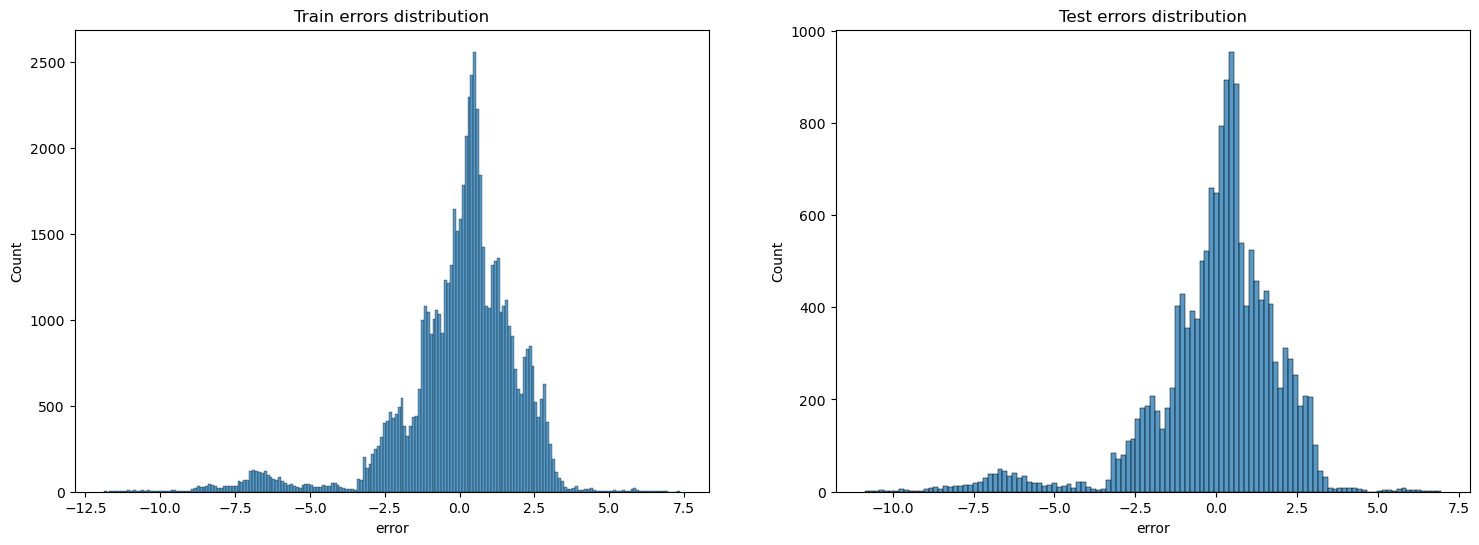

In [213]:
# Representación de sendos histogramas de los residuos de la regresión
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(poly_X_train["error"], ax=axes[0]).set(title="Train errors distribution")
sns.histplot(poly_X_test["error"], ax=axes[1]).set(title="Test errors distribution")

In [215]:
# Definición e impresión de algunos indicadores estadísticos relevantes
poly_mse = mean_squared_error(poly_y_test, poly_y_pred_test)
poly_rmse = mean_squared_error(poly_y_test, poly_y_pred_test, squared = False)
poly_r2 = r2_score(poly_y_test, poly_y_pred_test)

print("Mean Square Error (MSE):", poly_mse)
print("Root Mean Square Error (RMSE):", poly_rmse)
print("Coeficiente de determinación (R^2):", poly_r2)

Mean Square Error (MSE): 3.9760469103510974
Root Mean Square Error (RMSE): 1.994002735793283
Coeficiente de determinación (R^2): 0.9186891358299756


In [217]:
# Prueba de Shapiro-Wilk
sw_train = sm.stats.durbin_watson(poly_X_train["error"])
sw_test = sm.stats.durbin_watson(poly_X_test["error"])

# Prueba de Kolmogorov-Smirnov
ks_train = sm.stats.durbin_watson(poly_X_train["error"])
ks_test = sm.stats.durbin_watson(poly_X_test["error"])

print("Shapiro-Wilk test to Train set:", shapiro(poly_X_train["error"]))
print("Shapiro-Wilk test to Test set:", shapiro(poly_X_test["error"]))
print("\n")
print("Kolmogorov-Smirnov test to Train set:", kstest(poly_X_train["error"], "norm"))
print("Kolmogorov-Smirnov test to Test set:", kstest(poly_X_test["error"], "norm"))

Shapiro-Wilk test to Train set: ShapiroResult(statistic=0.8776895403862, pvalue=0.0)
Shapiro-Wilk test to Test set: ShapiroResult(statistic=0.8881770372390747, pvalue=0.0)


Kolmogorov-Smirnov test to Train set: KstestResult(statistic=0.13267783364776864, pvalue=0.0, statistic_location=1.1670254428570157, statistic_sign=-1)
Kolmogorov-Smirnov test to Test set: KstestResult(statistic=0.12654297748526744, pvalue=6.080110168745963e-222, statistic_location=1.2109995451313083, statistic_sign=-1)


De acuerdo con la prueba de Shapiro-Wilk, el p-valor casi nulo nos obliga a rechazar la hipotesis nula (h0) de que los residuos se distribuyen normalmente.  
De acuerdo con la prueba de Kolmogorov-Smirnov, el p-valor casi nulo nos obliga a rechazar la hipotesis nula (h0) de que los residuos se distribuyen normalmente.

Procedemos a aplicar la prueba de Durbin-Watson sobre la correlación de los residuos

In [221]:
dw_train = sm.stats.durbin_watson(poly_X_train["error"])
dw_test = sm.stats.durbin_watson(poly_X_test["error"])

print(f"Durbin-Watson statistic for training errors: {dw_train}")
print(f"Durbin-Watson statistic for test errors: {dw_test}")

Durbin-Watson statistic for training errors: 1.9965839686710471
Durbin-Watson statistic for test errors: 1.9905544159015185


In [223]:
# Otras comprobaciones de la bondad de ajuste del modelo

# Agregación de una columna de 1s para el intercepto
X_test_poly_with_intercept = sm.add_constant(X_test_poly)  

# Entrenamiento de un modelo de Mínimos Cuadrados Ordinarios con las variables seleccionadas
poly_model_stats = sm.OLS(poly_y_test, X_test_poly_with_intercept).fit()

print(poly_model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:          LINKUSD_Close   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.991e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:24:50   Log-Likelihood:                -33462.
No. Observations:               15867   AIC:                         6.694e+04
Df Residuals:                   15857   BIC:                         6.702e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8674      0.034    322.221      0.0

__Conclusiones__: son semejantes a las obtenidas con el modelo de regresión lineal. No obstante, y a diferencia del caso anterior:  

(i) La prueba Durbin-Watson arroja un valor muy cercano a 2, lo que sugeriría que no existe correlación entre los residuos.  
(ii) El MSE y el RMSE mejoran desde el 6,19 y 2,49, respectivamente, de la regresión lineal al 3,98  y 1,99, respectivamente, de la regresión polinómica.
621

Esto, a nuestro juicio, supone un pequeño avance respecto del anterior modelo, aunque insuficie Por ello, decidimos __descartar__ el modelo.

#### Entrenamiento de un modelo de redes neuronales

Aplicación de la técnica *random forest* para la determinación de las variables más relevantes respecto de la variable objetivo

In [228]:
# Definición de las variables
X = df_for_regression.drop(df_for_regression.columns[0], axis = 1)
y = df_for_regression[df_for_regression.columns[0]]

In [230]:
# Definición del modelo
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [231]:
# Definición de una variable que recoja la importancia de las variables
importancies = rf.feature_importances_
# Creación de una serie de pandas que contenga las variables y sus respectivas importancias
forest_importances = pd.Series(importancies, index=X.columns)

Text(0.5, 1.0, 'Importancia de las variables')

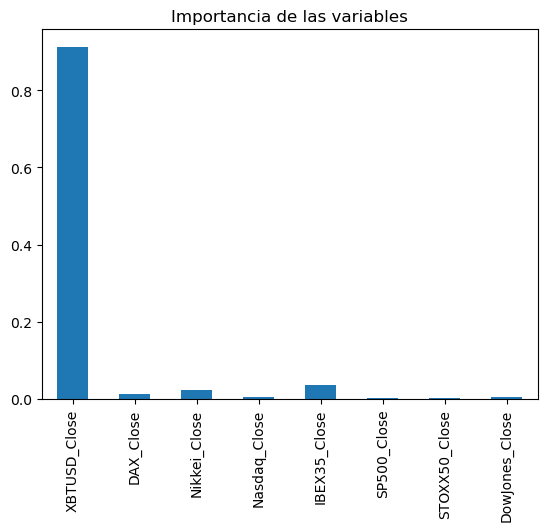

In [232]:
# Grafiación de la serie anterior
forest_importances.plot.bar().set_title("Importancia de las variables")

No sin sorpresa, el Bitcoin en la variable más importante con mucha ventaja sobre el resto. Procedemos a entrenar una red neuronal escogiendo las 4 mayores más importantes.

In [236]:
# Definición de las variables para el entrenamiento del modelo de redes neuronales
X_neural_network = df_for_regression[["XBTUSD_Close", "Nikkei_Close", "DAX_Close", "IBEX35_Close"]]
y_neural_network = df_for_regression[df_for_regression.columns[0]]

In [238]:
# Separación del dataset en entrenamiento y validación
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(X_neural_network, y_neural_network, test_size = 0.3, random_state=0)

In [240]:
# Definición del escalador
sc_X = StandardScaler()
# Escalado de los valores de las variables predictoras
nn_X_train_sc = sc_X.fit_transform(nn_X_train)
nn_X_test_sc = sc_X.transform(nn_X_test)

Aplicamos la técnica de *gridsearch* para elegir entre distintas estructuras de capas para el modelo

In [243]:
# Definición de los parámetros
param_grid = {
    "hidden_layer_sizes":[[4,4,4],
                          [8,7,4],
                          [10,8,5],
                          [20,13,10]],
    "activation":["relu"],
    "solver":["adam"],
    "max_iter":[500]
}

In [245]:
# Definición del modelo de gridsearch
gridsearch = GridSearchCV(MLPRegressor(), 
                          param_grid, 
                          cv = 5, 
                          verbose=1)

In [247]:
# Entrenamiento de los modelos
gridsearch.fit(nn_X_train_sc, nn_y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [[4, 4, 4], [8, 7, 4],
                                                [10, 8, 5], [20, 13, 10]],
                         'max_iter': [500], 'solver': ['adam']},
             verbose=1)

In [248]:
# Determinación del mejor modelo
gridsearch.best_estimator_
# Guardar en una variable
best_nn_model = gridsearch.best_estimator_

In [249]:
best_nn_model

MLPRegressor(hidden_layer_sizes=[20, 13, 10], max_iter=500)

In [250]:
# Evaluación del modelo para el dataset de entrenamiento

nn_y_train_predict = best_nn_model.predict(nn_X_train_sc)

# Mean Squared Error del modelo
nn_mse_train = mean_squared_error(nn_y_train, nn_y_train_predict)
# Root Mean Square Error del modelo
nn_rmse_train = mean_squared_error(nn_y_train, nn_y_train_predict, squared = False)
# R-Squared Score del modelo
nn_r2_train = r2_score(nn_y_train, nn_y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print("MSE is {}".format(nn_mse_train))
print("RMSE is {}".format(nn_rmse_train))
print("R2 score is {}".format(nn_r2_train))
print("\n")

# Evaluación del modelo para el dataset de validación

nn_y_test_predict = best_nn_model.predict(nn_X_test_sc)

# Mean Squared Error del modelo
nn_mse_test = mean_squared_error(nn_y_test, nn_y_test_predict)
# Root Mean Square Error del modelo
nn_rmse_test = mean_squared_error(nn_y_test, nn_y_test_predict, squared = False)
# R-Squared Score del modelo
nn_r2_test = r2_score(nn_y_test, nn_y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print("MSE is {}".format(nn_mse_test))
print("RMSE is {}".format(nn_rmse_test))
print("R2 score is {}".format(nn_r2_test))

The model performance for training set
--------------------------------------
MSE is 0.32013867067323215
RMSE is 0.5658079803901958
R2 score is 0.993677669121383


The model performance for testing set
--------------------------------------
MSE is 0.3097669029610548
RMSE is 0.5565670695981346
R2 score is 0.9937446172879787


In [251]:
# Creación de dos nuevas columnas para los sets de entrenamiento y test, que contienen sus respectivos residuos.
nn_X_train["error"] = nn_y_train_predict - nn_y_train
nn_X_test["error"] = nn_y_test_predict - nn_y_test

[Text(0.5, 1.0, 'Test errors distribution')]

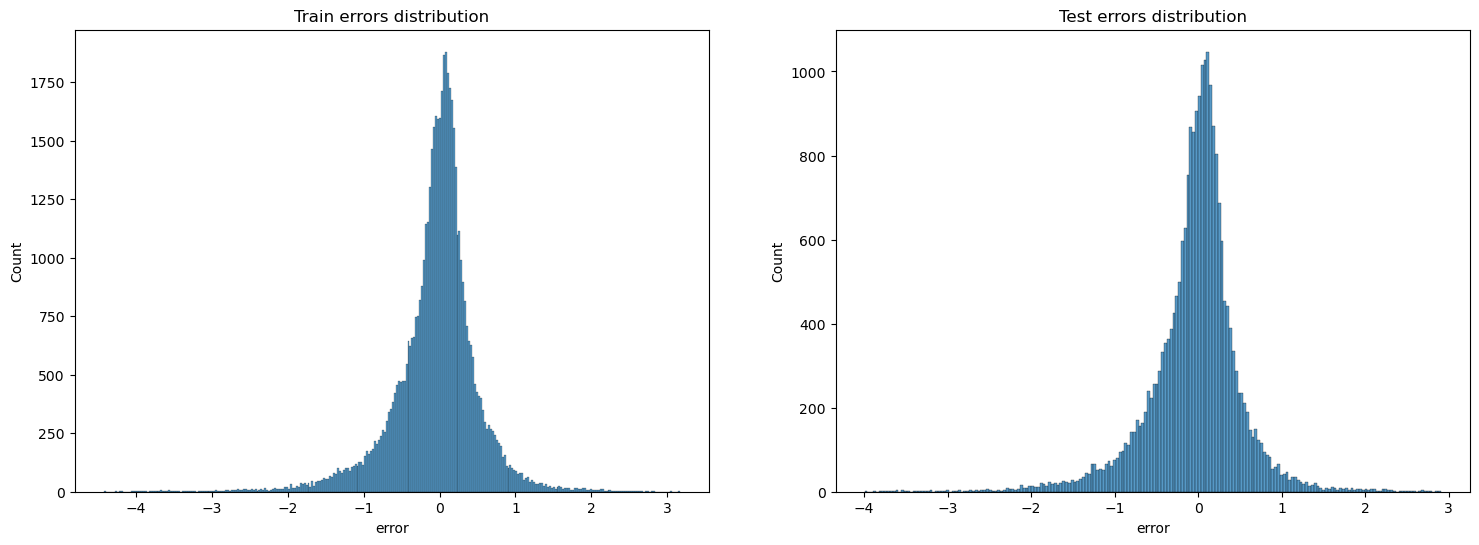

In [252]:
# Representación de sendos histogramas de los residuos de la regresión
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(nn_X_train["error"], ax=axes[0]).set(title="Train errors distribution")
sns.histplot(nn_X_test["error"], ax=axes[1]).set(title="Test errors distribution")

La distribución de los errores tiene una forma más leptocúrtica que la distribución normal con un ligero sesgo hacia la izquierda. Si bien ha mejorado sustancialmente el MSE y el RMSE de los modelos de regresión lineal y polinómica. Aplicación del test de Shapiro-Wilk y Kolmogorov-Smirnov:

In [254]:
# Prueba de Shapiro-Wilk
nn_sw_train = sm.stats.durbin_watson(nn_X_train["error"])
nn_sw_test = sm.stats.durbin_watson(nn_X_test["error"])

# Prueba de Kolmogorov-Smirnov
nn_ks_train = sm.stats.durbin_watson(nn_X_train["error"])
nn_ks_test = sm.stats.durbin_watson(nn_X_test["error"])

print("Shapiro-Wilk test to Train set:", shapiro(nn_X_train["error"]))
print("Shapiro-Wilk test to Test set:", shapiro(nn_X_test["error"]))
print("\n")
print("Kolmogorov-Smirnov test to Train set:", kstest(nn_X_train["error"], "norm"))
print("Kolmogorov-Smirnov test to Test set:", kstest(nn_X_test["error"], "norm"))

Shapiro-Wilk test to Train set: ShapiroResult(statistic=0.9170873165130615, pvalue=0.0)
Shapiro-Wilk test to Test set: ShapiroResult(statistic=0.9181909561157227, pvalue=0.0)


Kolmogorov-Smirnov test to Train set: KstestResult(statistic=0.20851510749414737, pvalue=0.0, statistic_location=0.4539500958181977, statistic_sign=1)
Kolmogorov-Smirnov test to Test set: KstestResult(statistic=0.21232528623215463, pvalue=0.0, statistic_location=0.45092232798942167, statistic_sign=1)


De nuevo, no podemos asegurar que los residuos se distribuyan normalmente.

Procedemos a aplicar la prueba de Durbin-Watson sobre la correlación de los residuos

In [257]:
nn_dw_train = sm.stats.durbin_watson(nn_X_train["error"])
nn_dw_test = sm.stats.durbin_watson(nn_X_test["error"])

print(f"Durbin-Watson statistic for training errors: {nn_dw_train}")
print(f"Durbin-Watson statistic for test errors: {nn_dw_test}")

Durbin-Watson statistic for training errors: 1.9837869423874934
Durbin-Watson statistic for test errors: 1.9813355519805742


Los valores son muy cercanos a 2, lo que sugiere que no existe correlación entre los residuos.

__Conclusión__: a nuestro juicio, el modelo de redes neuronales es el que mejor resultados ha obtenido, de entre los tres empleados. Procedemos a guardar el modelo.

In [269]:
# Guardar el modelo
LINK_nn_model = joblib.dump(best_nn_model, "./Models/LINK_nn_model.joblib")

#### Aplicación de *forward testing* al modelo

Vamos a evaluar el poder predictivo del modelo informándole series temporales que recogen las cotizaciones reales de las variables predictoras desde el 01/01/2024 hasta inicios de septiembre. Es decir, datos que el modelo no ha conocido ni en entrenamiento ni en test. Cuando el modelo devuelva la serie predicha de cotizaciones de Chainlink correspondientes a estas fechas, las compararemos con sus cotizaciones reales.

In [75]:
# Redefinimos todos los datasets, de modo que el primer registro empiece el 01/01/24 a las 00:00:00 h y el último acabe el 02/09/2024.
df_crypto_ftesting = df_crypto.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_bitcoin_ftesting = df_bitcoin.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_Nikkei_ftesting = df_Nikkei.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_Nasdaq_ftesting = df_Nasdaq.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_IBEX35_ftesting = df_IBEX35.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_DowJones_ftesting = df_DowJones.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_DAX_ftesting = df_DAX.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_SP500_ftesting = df_SP500.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]
df_STOXX50_ftesting = df_STOXX50.loc["2024-01-01 00:00:00":"2024-09-02 00:00:00"]

In [ ]:
# Eliminamos la columna usada para comprobar las frecuencias de cotización
df_crypto_ftesting = df_crypto_ftesting.iloc[:, [0]]
df_bitcoin_ftesting = df_bitcoin_ftesting.iloc[:, [0]]
df_DAX_ftesting = df_DAX_ftesting.iloc[:, [0]]
df_Nikkei_ftesting = df_Nikkei_ftesting.iloc[:, [0]]
df_DowJones_ftesting = df_DowJones_ftesting.iloc[:, [0]]
df_IBEX35_ftesting = df_IBEX35_ftesting.iloc[:, [0]]
df_Nasdaq_ftesting = df_Nasdaq_ftesting.iloc[:, [0]]
df_SP500_ftesting = df_SP500_ftesting.iloc[:, [0]]
df_STOXX50_ftesting = df_STOXX50_ftesting.iloc[:, [0]]

In [77]:
# Fusión de los datasets de las variables predictoras en función de la columna "DateTime".
df_predictors_ftesting = (
    df_bitcoin_ftesting   
    .merge(df_Nikkei_ftesting, how="left", on="DateTime")
    .merge(df_DAX_ftesting, how="left", on="DateTime")
    .merge(df_IBEX35_ftesting, how="left", on="DateTime")
)

In [79]:
df_predictors_ftesting

,XBTUSD_Close,Nikkei_Close,DAX_Close,IBEX35_Close
DateTime,,,,
2024-01-01 00:00:00,42449.9,NaN,NaN,NaN
2024-01-01 00:15:00,42430.0,NaN,NaN,NaN
2024-01-01 00:30:00,42433.1,NaN,NaN,NaN
2024-01-01 00:45:00,42452.6,NaN,NaN,NaN
2024-01-01 01:00:00,42431.2,NaN,NaN,NaN
...,...,...,...,...
2024-09-01 23:00:00,57309.9,NaN,NaN,NaN
2024-09-01 23:15:00,57397.2,NaN,NaN,NaN
2024-09-01 23:30:00,57320.0,NaN,NaN,NaN


In [81]:
# Bucle para rellenar los valores faltantes en las variables, replicando el valor anterior disponible
for col in df_predictors_ftesting.columns:
    df_predictors_ftesting[col] = df_predictors_ftesting[col].fillna(method = "bfill").fillna(method = "ffill")

In [83]:
df_predictors_ftesting

,XBTUSD_Close,Nikkei_Close,DAX_Close,IBEX35_Close
DateTime,,,,
2024-01-01 00:00:00,42449.9,32745.0,16847.50,10218.650391
2024-01-01 00:15:00,42430.0,32745.0,16847.50,10218.650391
2024-01-01 00:30:00,42433.1,32745.0,16847.50,10218.650391
2024-01-01 00:45:00,42452.6,32745.0,16847.50,10218.650391
2024-01-01 01:00:00,42431.2,32745.0,16847.50,10218.650391
...,...,...,...,...
2024-09-01 23:00:00,57309.9,39015.5,18898.75,11401.900391
2024-09-01 23:15:00,57397.2,39015.5,18898.75,11401.900391
2024-09-01 23:30:00,57320.0,39015.5,18898.75,11401.900391


In [85]:
# Definición del escalador
sc_X = StandardScaler()
# Escalado de los valores de las variables predictoras
nn_predictors_sc = sc_X.fit_transform(df_predictors_ftesting)

In [87]:
# Cargar el modelo de regresión lineal múltiple desde el archivo
load_LINK_nn_model = joblib.load("./Models/LINK_nn_model.joblib")

# Predicciones con el modelo de regresión lineal múltiple cargado
nn_predictions = load_LINK_nn_model.predict(nn_predictors_sc)

In [89]:
df_px_pred = pd.DataFrame(nn_predictions)
df_px_pred = df_px_pred.rename(columns = {0:"LINKUSD_Close prediction"})

Comparativa de los resultados obtenidos

In [286]:
# Asignar el índice (fechas de cotización) del dataframe de cotizaciones reales del Ethereum al dataframe de cotizaciones predichas
df_px_pred = df_px_pred.iloc[:len(df_crypto_ftesting)]
df_px_pred.index = df_crypto_ftesting.index
df_px_pred

,ETHUSD_Close prediction
DateTime,
2024-01-01 00:00:00,1419.376655
2024-01-01 00:15:00,1419.093830
2024-01-01 00:30:00,1419.137888
2024-01-01 00:45:00,1419.415028
2024-01-01 01:00:00,1419.110885
...,...
2024-09-01 23:00:00,1758.131607
2024-09-01 23:15:00,1760.106481
2024-09-01 23:30:00,1766.468345


In [288]:
# Fusionar los dataframes para comprar resultados
df_results_comp = df_crypto_ftesting.merge(df_px_pred, how = "left", on = "DateTime")
# Crear columna que refleje los residuos
df_results_comp["Difference"] = df_results_comp["LINKSD_Close"] - df_results_comp["LINKUSD_Close prediction"]

__Conclusión__: una comparativa rápida revela muy importantes diferencias entre los valores reales y los valores predichos, principalmente al inicio de la serie. Lo que revela la inutilidad del modelo en la práctica.